In [1]:
import os
import sys

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import io
import torch
import subprocess
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from huggingface_hub import snapshot_download

In [2]:
repo_dir = "satvision-toa"

if not os.path.exists(repo_dir):
    subprocess.run(["git", "clone", "https://github.com/nasa-nccs-hpda/satvision-toa"])
else:
    subprocess.run(["git", "-C", repo_dir, "pull"])

Already up to date.


In [3]:
sys.path.append("satvision-toa")
from satvision_toa.configs.config import _C, _update_config_from_file
from satvision_toa.models.mim import build_mim_model

In [ ]:
from satvision_toa.datasets.ocean_color_dataset import OceanColorDataset
from satvision_toa.models.decoders.ocean_color_decoder import (
    OceanColorUNETV2, OceanColorFCNV3,
    OceanColorFCNV2, OceanColorFCNV2point5
)
from satvision_toa.models.decoders.ocean_color_e2e_decoder import (
    OceanColorFCN, OceanColorUNET
)

from satvision_toa.transforms.ocean_color import (
    GlobalMinMaxNorm, PBMinMaxNorm, ScaleAndOffset
)

from satvision_toa.data_utils.utils_ocean_color import (
    load_config, get_dataloaders, train_model
)

In [4]:
full_dir = "/panfs/ccds02/nobackup/people/ajkerr1/SatVision/OceanColor"

## SV Model

In [5]:
train_dir = os.path.join(full_dir, "chips/ft/chips_ft")
test_dir = os.path.join(full_dir, "chips/ft/val_chips_ft")

In [6]:
config = load_config()
model = build_mim_model(config)
model = OceanColorFCNV2point5(
    swin_encoder=model.encoder, freeze_encoder=True
)

=> merge config from /home/ajkerr1/.cache/huggingface/hub/models--nasa-cisto-data-science-group--downstream-satvision-toa-3dclouds/snapshots/1c6d3b4fba1a476956027e56d5dd9708bdfef0ba/mim_pretrain_swinv2_satvision_giant_128_window08_50ep.yaml


/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Freezing encoder


In [7]:
# ADJUST FOR TRAINING UNET VS SATVISION
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dir, test_dir, num_inputs=14, batch_size=64
)

num_epochs = 100
save_every = 20
test_every = 10
save_path = "sv_unet"
pdf_path = "pred_pdfs/svtoa"
metrics_filename = "sv_metrics"
train_losses, val_losses = train_model(
    model, train_dataloader, val_dataloader, test_dataloader, num_epochs=num_epochs, 
    save_path=save_path, save_every=save_every, test_every=test_every, pdf_path=pdf_path, 
    metrics_filename=metrics_filename
)

/panfs/ccds02/nobackup/people/ajkerr1/SatVision/OceanColor/fine_tuning/ocean_color_transforms.py:147: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


Data shape: torch.Size([14, 128, 128])
Label shape: torch.Size([1, 128, 128])
train & val size: (144, 37)
Decoder weights initialized with Kaiming/Xavier initialization
Starting training for 100 epochs on cuda
Model parameters: 640,583,393


Epoch 1/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 1/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.39s/it, Loss=0.260676, Avg=0.283162, LR=1.00e-04]
                                                                                                            
Epoch 1/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.693302, MAE=0.681124]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   1%|          | 1/100 [00:37<1:02:24, 37.83s/it, Train_Loss=0.2832, Val_Loss=0.6933, Val_MAE=0.6811, Time=37.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_02_1ep.pdf



Epoch 2/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 2/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.36s/it, Loss=0.238906, Avg=0.206738, LR=1.00e-04]
                                                                                                            
Epoch 2/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, Loss=0.659601, MAE=0.648615]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   2%|▏         | 2/100 [01:14<1:01:01, 37.36s/it, Train_Loss=0.2067, Val_Loss=0.6596, Val_MAE=0.6486, Time=37.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_03_2ep.pdf



Epoch 3/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 3/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.37s/it, Loss=0.233280, Avg=0.180647, LR=9.99e-05]
                                                                                                            
Epoch 3/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.512175, MAE=0.502737]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   3%|▎         | 3/100 [01:52<1:00:18, 37.31s/it, Train_Loss=0.1806, Val_Loss=0.5122, Val_MAE=0.5027, Time=37.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_04_3ep.pdf



Epoch 4/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 4/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.37s/it, Loss=0.245704, Avg=0.171266, LR=9.98e-05]
                                                                                                            
Epoch 4/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.322735, MAE=0.314227]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   4%|▍         | 4/100 [02:29<59:32, 37.22s/it, Train_Loss=0.1713, Val_Loss=0.3227, Val_MAE=0.3142, Time=37.1s]  

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_04_4ep.pdf



Epoch 5/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 5/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.127621, Avg=0.147050, LR=9.96e-05]
                                                                                                            
Epoch 5/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, Loss=0.214814, MAE=0.207048]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   5%|▌         | 5/100 [03:06<59:03, 37.30s/it, Train_Loss=0.1471, Val_Loss=0.2148, Val_MAE=0.2070, Time=37.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_05_5ep.pdf



Epoch 6/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 6/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.203109, Avg=0.153443, LR=9.94e-05]
                                                                                                            
Epoch 6/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.210296, MAE=0.202636]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   6%|▌         | 6/100 [03:43<58:21, 37.25s/it, Train_Loss=0.1534, Val_Loss=0.2103, Val_MAE=0.2026, Time=37.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_05_6ep.pdf



Epoch 7/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 7/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.165165, Avg=0.145940, LR=9.91e-05]
                                                                                                            
Epoch 7/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, Loss=0.233700, MAE=0.225757]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   7%|▋         | 7/100 [04:21<57:52, 37.34s/it, Train_Loss=0.1459, Val_Loss=0.2337, Val_MAE=0.2258, Time=37.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_06_7ep.pdf



Epoch 8/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 8/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.170418, Avg=0.147014, LR=9.88e-05]
                                                                                                            
Epoch 8/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, Loss=0.164345, MAE=0.156884]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   8%|▊         | 8/100 [04:58<57:11, 37.30s/it, Train_Loss=0.1470, Val_Loss=0.1643, Val_MAE=0.1569, Time=37.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_07_8ep.pdf



Epoch 9/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 9/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.214606, Avg=0.151199, LR=9.84e-05]
                                                                                                            
Epoch 9/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, Loss=0.150092, MAE=0.142756]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   9%|▉         | 9/100 [05:35<56:31, 37.27s/it, Train_Loss=0.1512, Val_Loss=0.1501, Val_MAE=0.1428, Time=37.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_07_9ep.pdf



Epoch 10/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 10/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.241868, Avg=0.157098, LR=9.80e-05]
                                                                                                             
Epoch 10/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, Loss=0.162342, MAE=0.154908]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  10%|█         | 10/100 [06:13<56:04, 37.38s/it, Train_Loss=0.1571, Val_Loss=0.1623, Val_MAE=0.1549, Time=37.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_08_10ep.pdf



Epoch 11/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 11/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.144194, Avg=0.137287, LR=9.76e-05]
                                                                                                             
Epoch 11/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, Loss=0.145030, MAE=0.137657]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  11%|█         | 11/100 [06:50<55:25, 37.36s/it, Train_Loss=0.1373, Val_Loss=0.1450, Val_MAE=0.1377, Time=37.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_09_11ep.pdf



Epoch 12/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 12/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.180765, Avg=0.140927, LR=9.71e-05]
                                                                                                             
Epoch 12/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, Loss=0.148456, MAE=0.141142]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  12%|█▏        | 12/100 [07:27<54:46, 37.35s/it, Train_Loss=0.1409, Val_Loss=0.1485, Val_MAE=0.1411, Time=37.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_09_12ep.pdf



Epoch 13/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 13/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.132153, Avg=0.135058, LR=9.65e-05]
                                                                                                             
Epoch 13/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, Loss=0.144164, MAE=0.136731]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  13%|█▎        | 13/100 [08:05<54:23, 37.51s/it, Train_Loss=0.1351, Val_Loss=0.1442, Val_MAE=0.1367, Time=37.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_10_13ep.pdf



Epoch 14/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 14/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.178793, Avg=0.139655, LR=9.59e-05]
                                                                                                             
Epoch 14/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, Loss=0.143626, MAE=0.136177]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  14%|█▍        | 14/100 [08:43<53:43, 37.48s/it, Train_Loss=0.1397, Val_Loss=0.1436, Val_MAE=0.1362, Time=37.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_10_14ep.pdf



Epoch 15/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 15/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.168027, Avg=0.136453, LR=9.53e-05]
                                                                                                             
Epoch 15/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, Loss=0.177292, MAE=0.169607]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  15%|█▌        | 15/100 [09:20<53:03, 37.45s/it, Train_Loss=0.1365, Val_Loss=0.1773, Val_MAE=0.1696, Time=37.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_11_15ep.pdf



Epoch 16/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 16/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.165740, Avg=0.134502, LR=9.46e-05]
                                                                                                             
Epoch 16/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss=0.182904, MAE=0.175228]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  16%|█▌        | 16/100 [09:58<52:44, 37.68s/it, Train_Loss=0.1345, Val_Loss=0.1829, Val_MAE=0.1752, Time=38.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_12_16ep.pdf



Epoch 17/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 17/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.164811, Avg=0.135239, LR=9.39e-05]
                                                                                                             
Epoch 17/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss=0.181853, MAE=0.174202]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  17%|█▋        | 17/100 [10:36<52:04, 37.65s/it, Train_Loss=0.1352, Val_Loss=0.1819, Val_MAE=0.1742, Time=37.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_12_17ep.pdf



Epoch 18/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 18/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.239643, Avg=0.147761, LR=9.31e-05]
                                                                                                             
Epoch 18/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, Loss=0.160557, MAE=0.153016]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  18%|█▊        | 18/100 [11:14<51:25, 37.63s/it, Train_Loss=0.1478, Val_Loss=0.1606, Val_MAE=0.1530, Time=37.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_13_18ep.pdf



Epoch 19/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 19/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.134355, Avg=0.127333, LR=9.23e-05]
                                                                                                             
Epoch 19/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, Loss=0.201678, MAE=0.193822]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  19%|█▉        | 19/100 [11:51<50:46, 37.62s/it, Train_Loss=0.1273, Val_Loss=0.2017, Val_MAE=0.1938, Time=37.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_14_19ep.pdf



Epoch 20/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 20/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.156847, Avg=0.128761, LR=9.14e-05]
                                                                                                             
Epoch 20/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss=0.139653, MAE=0.132326]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  19%|█▉        | 19/100 [12:29<50:46, 37.62s/it, Train_Loss=0.1288, Val_Loss=0.1397, Val_MAE=0.1323, Time=38.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_14_20ep.pdf


Training Progress:  20%|██        | 20/100 [13:06<1:05:08, 48.86s/it, Train_Loss=0.1288, Val_Loss=0.1397, Val_MAE=0.1323, Time=38.4s]

New best model saved at epoch 20! Val Loss: 0.139653



Epoch 21/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 21/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.37s/it, Loss=0.150567, Avg=0.126768, LR=9.05e-05]
                                                                                                             
Epoch 21/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss=0.127735, MAE=0.120450]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  21%|██        | 21/100 [13:44<59:52, 45.48s/it, Train_Loss=0.1268, Val_Loss=0.1277, Val_MAE=0.1204, Time=37.6s]  

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_15_21ep.pdf



Epoch 22/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 22/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.134039, Avg=0.122411, LR=8.96e-05]
                                                                                                             
Epoch 22/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss=0.127930, MAE=0.120609]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  22%|██▏       | 22/100 [14:22<56:06, 43.16s/it, Train_Loss=0.1224, Val_Loss=0.1279, Val_MAE=0.1206, Time=37.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_16_22ep.pdf



Epoch 23/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 23/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.146663, Avg=0.124182, LR=8.86e-05]
                                                                                                             
Epoch 23/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it, Loss=0.132088, MAE=0.124735]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  23%|██▎       | 23/100 [14:59<53:20, 41.56s/it, Train_Loss=0.1242, Val_Loss=0.1321, Val_MAE=0.1247, Time=37.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_17_23ep.pdf



Epoch 24/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 24/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.145327, Avg=0.124025, LR=8.76e-05]
                                                                                                             
Epoch 24/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, Loss=0.155517, MAE=0.148060]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  24%|██▍       | 24/100 [15:38<51:32, 40.69s/it, Train_Loss=0.1240, Val_Loss=0.1555, Val_MAE=0.1481, Time=38.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_17_24ep.pdf



Epoch 25/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 25/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.116716, Avg=0.116236, LR=8.66e-05]
                                                                                                             
Epoch 25/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, Loss=0.143837, MAE=0.136462]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  25%|██▌       | 25/100 [16:16<49:49, 39.87s/it, Train_Loss=0.1162, Val_Loss=0.1438, Val_MAE=0.1365, Time=37.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_18_25ep.pdf



Epoch 26/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 26/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.109758, Avg=0.112419, LR=8.55e-05]
                                                                                                             
Epoch 26/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, Loss=0.121606, MAE=0.114429]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  26%|██▌       | 26/100 [16:54<48:29, 39.32s/it, Train_Loss=0.1124, Val_Loss=0.1216, Val_MAE=0.1144, Time=38.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_19_26ep.pdf



Epoch 27/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 27/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.163058, Avg=0.120075, LR=8.44e-05]
                                                                                                             
Epoch 27/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, Loss=0.132916, MAE=0.125703]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  27%|██▋       | 27/100 [17:32<47:21, 38.93s/it, Train_Loss=0.1201, Val_Loss=0.1329, Val_MAE=0.1257, Time=38.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_19_27ep.pdf



Epoch 28/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 28/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.143010, Avg=0.114639, LR=8.32e-05]
                                                                                                             
Epoch 28/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, Loss=0.126219, MAE=0.118885]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  28%|██▊       | 28/100 [18:10<46:23, 38.66s/it, Train_Loss=0.1146, Val_Loss=0.1262, Val_MAE=0.1189, Time=38.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_20_28ep.pdf



Epoch 29/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 29/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.143266, Avg=0.114452, LR=8.21e-05]
                                                                                                             
Epoch 29/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, Loss=0.194879, MAE=0.186943]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  29%|██▉       | 29/100 [18:49<45:49, 38.72s/it, Train_Loss=0.1145, Val_Loss=0.1949, Val_MAE=0.1869, Time=38.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_21_29ep.pdf



Epoch 30/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 30/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.141706, Avg=0.116622, LR=8.08e-05]
                                                                                                             
Epoch 30/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, Loss=0.158752, MAE=0.151077]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  30%|███       | 30/100 [19:27<44:56, 38.53s/it, Train_Loss=0.1166, Val_Loss=0.1588, Val_MAE=0.1511, Time=38.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_21_30ep.pdf



Epoch 31/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 31/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.154774, Avg=0.119555, LR=7.96e-05]
                                                                                                             
Epoch 31/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, Loss=0.157610, MAE=0.150025]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  31%|███       | 31/100 [20:05<44:10, 38.41s/it, Train_Loss=0.1196, Val_Loss=0.1576, Val_MAE=0.1500, Time=38.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_22_31ep.pdf



Epoch 32/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 32/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.127927, Avg=0.112296, LR=7.83e-05]
                                                                                                             
Epoch 32/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, Loss=0.134910, MAE=0.127467]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  32%|███▏      | 32/100 [20:43<43:29, 38.37s/it, Train_Loss=0.1123, Val_Loss=0.1349, Val_MAE=0.1275, Time=38.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_22_32ep.pdf



Epoch 33/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 33/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.130047, Avg=0.111986, LR=7.70e-05]
                                                                                                             
Epoch 33/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, Loss=0.147702, MAE=0.140270]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  33%|███▎      | 33/100 [21:22<42:48, 38.34s/it, Train_Loss=0.1120, Val_Loss=0.1477, Val_MAE=0.1403, Time=38.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_23_33ep.pdf



Epoch 34/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 34/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.187264, Avg=0.117801, LR=7.57e-05]
                                                                                                             
Epoch 34/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, Loss=0.143901, MAE=0.136568]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  34%|███▍      | 34/100 [22:00<42:08, 38.32s/it, Train_Loss=0.1178, Val_Loss=0.1439, Val_MAE=0.1366, Time=38.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_24_34ep.pdf



Epoch 35/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 35/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.73s/it, Loss=0.210594, Avg=0.126139, LR=7.43e-05]
                                                                                                             
Epoch 35/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, Loss=0.144205, MAE=0.136799]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  35%|███▌      | 35/100 [22:39<41:48, 38.59s/it, Train_Loss=0.1261, Val_Loss=0.1442, Val_MAE=0.1368, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_24_35ep.pdf



Epoch 36/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 36/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.125179, Avg=0.109340, LR=7.30e-05]
                                                                                                             
Epoch 36/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it, Loss=0.139014, MAE=0.131509]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  36%|███▌      | 36/100 [23:18<41:06, 38.54s/it, Train_Loss=0.1093, Val_Loss=0.1390, Val_MAE=0.1315, Time=38.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_25_36ep.pdf



Epoch 37/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 37/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.140482, Avg=0.113576, LR=7.16e-05]
                                                                                                             
Epoch 37/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, Loss=0.143945, MAE=0.136432]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  37%|███▋      | 37/100 [23:56<40:25, 38.50s/it, Train_Loss=0.1136, Val_Loss=0.1439, Val_MAE=0.1364, Time=38.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_26_37ep.pdf



Epoch 38/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 38/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.112217, Avg=0.108478, LR=7.02e-05]
                                                                                                             
Epoch 38/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it, Loss=0.132117, MAE=0.124793]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  38%|███▊      | 38/100 [24:34<39:46, 38.49s/it, Train_Loss=0.1085, Val_Loss=0.1321, Val_MAE=0.1248, Time=38.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_26_38ep.pdf



Epoch 39/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 39/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.117357, Avg=0.109779, LR=6.87e-05]
                                                                                                             
Epoch 39/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, Loss=0.119728, MAE=0.112403]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  39%|███▉      | 39/100 [25:13<39:07, 38.48s/it, Train_Loss=0.1098, Val_Loss=0.1197, Val_MAE=0.1124, Time=38.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_27_39ep.pdf



Epoch 40/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 40/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.098506, Avg=0.104296, LR=6.73e-05]
                                                                                                             
Epoch 40/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, Loss=0.131949, MAE=0.124638]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  39%|███▉      | 39/100 [25:52<39:07, 38.48s/it, Train_Loss=0.1043, Val_Loss=0.1319, Val_MAE=0.1246, Time=38.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_28_40ep.pdf


Training Progress:  40%|████      | 40/100 [26:29<49:53, 49.89s/it, Train_Loss=0.1043, Val_Loss=0.1319, Val_MAE=0.1246, Time=38.6s]

New best model saved at epoch 40! Val Loss: 0.131949



Epoch 41/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 41/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.37s/it, Loss=0.122248, Avg=0.107121, LR=6.58e-05]
                                                                                                             
Epoch 41/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, Loss=0.115031, MAE=0.107795]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  41%|████      | 41/100 [27:09<45:58, 46.76s/it, Train_Loss=0.1071, Val_Loss=0.1150, Val_MAE=0.1078, Time=39.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_29_41ep.pdf



Epoch 42/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 42/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.111927, Avg=0.105486, LR=6.43e-05]
                                                                                                             
Epoch 42/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, Loss=0.127520, MAE=0.120195]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  42%|████▏     | 42/100 [27:48<42:50, 44.32s/it, Train_Loss=0.1055, Val_Loss=0.1275, Val_MAE=0.1202, Time=38.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_30_42ep.pdf



Epoch 43/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 43/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.39s/it, Loss=0.127803, Avg=0.103186, LR=6.28e-05]
                                                                                                             
Epoch 43/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, Loss=0.119547, MAE=0.112282]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  43%|████▎     | 43/100 [28:26<40:27, 42.59s/it, Train_Loss=0.1032, Val_Loss=0.1195, Val_MAE=0.1123, Time=38.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_30_43ep.pdf



Epoch 44/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 44/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.117502, Avg=0.102784, LR=6.13e-05]
                                                                                                             
Epoch 44/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it, Loss=0.114377, MAE=0.107175]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  44%|████▍     | 44/100 [29:05<38:39, 41.42s/it, Train_Loss=0.1028, Val_Loss=0.1144, Val_MAE=0.1072, Time=38.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_31_44ep.pdf



Epoch 45/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 45/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.123223, Avg=0.102676, LR=5.98e-05]
                                                                                                             
Epoch 45/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it, Loss=0.111582, MAE=0.104450]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  45%|████▌     | 45/100 [29:44<37:14, 40.63s/it, Train_Loss=0.1027, Val_Loss=0.1116, Val_MAE=0.1044, Time=38.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_31_45ep.pdf



Epoch 46/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 46/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.120141, Avg=0.101402, LR=5.82e-05]
                                                                                                             
Epoch 46/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, Loss=0.113789, MAE=0.106580]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  46%|████▌     | 46/100 [30:22<36:05, 40.10s/it, Train_Loss=0.1014, Val_Loss=0.1138, Val_MAE=0.1066, Time=38.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_32_46ep.pdf



Epoch 47/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 47/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.132090, Avg=0.103879, LR=5.67e-05]
                                                                                                             
Epoch 47/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, Loss=0.125194, MAE=0.117900]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  47%|████▋     | 47/100 [31:01<35:04, 39.71s/it, Train_Loss=0.1039, Val_Loss=0.1252, Val_MAE=0.1179, Time=38.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_33_47ep.pdf



Epoch 48/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 48/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.097161, Avg=0.098047, LR=5.52e-05]
                                                                                                             
Epoch 48/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, Loss=0.118001, MAE=0.110788]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  48%|████▊     | 48/100 [31:40<34:11, 39.45s/it, Train_Loss=0.0980, Val_Loss=0.1180, Val_MAE=0.1108, Time=38.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_33_48ep.pdf



Epoch 49/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 49/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.139736, Avg=0.104399, LR=5.36e-05]
                                                                                                             
Epoch 49/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it, Loss=0.118276, MAE=0.111046]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  49%|████▉     | 49/100 [32:20<33:43, 39.67s/it, Train_Loss=0.1044, Val_Loss=0.1183, Val_MAE=0.1110, Time=40.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_34_49ep.pdf



Epoch 50/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 50/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.40s/it, Loss=0.138881, Avg=0.101623, LR=5.21e-05]
                                                                                                             
Epoch 50/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, Loss=0.116775, MAE=0.109456]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  50%|█████     | 50/100 [32:59<32:51, 39.43s/it, Train_Loss=0.1016, Val_Loss=0.1168, Val_MAE=0.1095, Time=38.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_35_50ep.pdf



Epoch 51/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 51/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.165043, Avg=0.109241, LR=5.05e-05]
                                                                                                             
Epoch 51/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it, Loss=0.122362, MAE=0.115051]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  51%|█████     | 51/100 [33:38<32:04, 39.27s/it, Train_Loss=0.1092, Val_Loss=0.1224, Val_MAE=0.1151, Time=38.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_35_51ep.pdf



Epoch 52/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 52/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.130491, Avg=0.103040, LR=4.89e-05]
                                                                                                             
Epoch 52/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, Loss=0.129713, MAE=0.122456]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  52%|█████▏    | 52/100 [34:17<31:20, 39.18s/it, Train_Loss=0.1030, Val_Loss=0.1297, Val_MAE=0.1225, Time=39.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_36_52ep.pdf



Epoch 53/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 53/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.126308, Avg=0.100882, LR=4.74e-05]
                                                                                                             
Epoch 53/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, Loss=0.110870, MAE=0.103712]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  53%|█████▎    | 53/100 [34:56<30:40, 39.16s/it, Train_Loss=0.1009, Val_Loss=0.1109, Val_MAE=0.1037, Time=39.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_37_53ep.pdf



Epoch 54/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 54/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.102918, Avg=0.099355, LR=4.58e-05]
                                                                                                             
Epoch 54/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, Loss=0.117996, MAE=0.110784]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  54%|█████▍    | 54/100 [35:35<30:00, 39.13s/it, Train_Loss=0.0994, Val_Loss=0.1180, Val_MAE=0.1108, Time=39.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_37_54ep.pdf



Epoch 55/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 55/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.126024, Avg=0.102130, LR=4.43e-05]
                                                                                                             
Epoch 55/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, Loss=0.112171, MAE=0.104988]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  55%|█████▌    | 55/100 [36:14<29:21, 39.14s/it, Train_Loss=0.1021, Val_Loss=0.1122, Val_MAE=0.1050, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_38_55ep.pdf



Epoch 56/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 56/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.107250, Avg=0.095813, LR=4.28e-05]
                                                                                                             
Epoch 56/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it, Loss=0.109752, MAE=0.102559]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  56%|█████▌    | 56/100 [36:53<28:42, 39.15s/it, Train_Loss=0.0958, Val_Loss=0.1098, Val_MAE=0.1026, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_39_56ep.pdf



Epoch 57/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 57/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.123149, Avg=0.097083, LR=4.12e-05]
                                                                                                             
Epoch 57/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, Loss=0.114570, MAE=0.107359]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  57%|█████▋    | 57/100 [37:33<28:03, 39.16s/it, Train_Loss=0.0971, Val_Loss=0.1146, Val_MAE=0.1074, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_39_57ep.pdf



Epoch 58/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 58/100 [Train]: 100%|██████████| 6/6 [00:34<00:00,  4.93s/it, Loss=0.121042, Avg=0.098045, LR=3.97e-05]
                                                                                                             
Epoch 58/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, Loss=0.116143, MAE=0.108958]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  58%|█████▊    | 58/100 [38:14<27:46, 39.67s/it, Train_Loss=0.0980, Val_Loss=0.1161, Val_MAE=0.1090, Time=40.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_40_58ep.pdf



Epoch 59/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 59/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.130645, Avg=0.098829, LR=3.82e-05]
                                                                                                             
Epoch 59/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, Loss=0.119099, MAE=0.111916]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  59%|█████▉    | 59/100 [38:53<27:00, 39.53s/it, Train_Loss=0.0988, Val_Loss=0.1191, Val_MAE=0.1119, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_41_59ep.pdf



Epoch 60/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 60/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.132480, Avg=0.098155, LR=3.67e-05]
                                                                                                             
Epoch 60/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it, Loss=0.120344, MAE=0.113147]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  59%|█████▉    | 59/100 [39:32<27:00, 39.53s/it, Train_Loss=0.0982, Val_Loss=0.1203, Val_MAE=0.1131, Time=39.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_41_60ep.pdf


Training Progress:  60%|██████    | 60/100 [40:10<33:56, 50.92s/it, Train_Loss=0.0982, Val_Loss=0.1203, Val_MAE=0.1131, Time=39.3s]

New best model saved at epoch 60! Val Loss: 0.120344



Epoch 61/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 61/100 [Train]: 100%|██████████| 6/6 [00:32<00:00,  4.38s/it, Loss=0.119938, Avg=0.096279, LR=3.52e-05]
                                                                                                             
Epoch 61/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, Loss=0.108478, MAE=0.101335]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  61%|██████    | 61/100 [40:49<30:46, 47.34s/it, Train_Loss=0.0963, Val_Loss=0.1085, Val_MAE=0.1013, Time=39.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_43_61ep.pdf



Epoch 62/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 62/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.115094, Avg=0.093871, LR=3.37e-05]
                                                                                                             
Epoch 62/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it, Loss=0.113786, MAE=0.106594]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  62%|██████▏   | 62/100 [41:28<28:26, 44.90s/it, Train_Loss=0.0939, Val_Loss=0.1138, Val_MAE=0.1066, Time=39.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_43_62ep.pdf



Epoch 63/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 63/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.101506, Avg=0.091131, LR=3.23e-05]
                                                                                                             
Epoch 63/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it, Loss=0.139040, MAE=0.131676]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  63%|██████▎   | 63/100 [42:08<26:41, 43.29s/it, Train_Loss=0.0911, Val_Loss=0.1390, Val_MAE=0.1317, Time=39.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_44_63ep.pdf



Epoch 64/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 64/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.115277, Avg=0.093238, LR=3.08e-05]
                                                                                                             
Epoch 64/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, Loss=0.106792, MAE=0.099608]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  64%|██████▍   | 64/100 [42:47<25:16, 42.11s/it, Train_Loss=0.0932, Val_Loss=0.1068, Val_MAE=0.0996, Time=39.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_45_64ep.pdf



Epoch 65/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 65/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.101144, Avg=0.090439, LR=2.94e-05]
                                                                                                             
Epoch 65/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, Loss=0.112067, MAE=0.104890]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  65%|██████▌   | 65/100 [43:27<24:05, 41.31s/it, Train_Loss=0.0904, Val_Loss=0.1121, Val_MAE=0.1049, Time=39.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_45_65ep.pdf



Epoch 66/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 66/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.100484, Avg=0.092819, LR=2.80e-05]
                                                                                                             
Epoch 66/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, Loss=0.118599, MAE=0.111393]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  66%|██████▌   | 66/100 [44:06<23:06, 40.77s/it, Train_Loss=0.0928, Val_Loss=0.1186, Val_MAE=0.1114, Time=39.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_46_66ep.pdf



Epoch 67/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 67/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.097802, Avg=0.089922, LR=2.67e-05]
                                                                                                             
Epoch 67/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, Loss=0.103024, MAE=0.095906]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  67%|██████▋   | 67/100 [44:46<22:12, 40.38s/it, Train_Loss=0.0899, Val_Loss=0.1030, Val_MAE=0.0959, Time=39.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_47_67ep.pdf



Epoch 68/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 68/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.104296, Avg=0.089784, LR=2.53e-05]
                                                                                                             
Epoch 68/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss=0.106491, MAE=0.099357]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  68%|██████▊   | 68/100 [45:27<21:40, 40.63s/it, Train_Loss=0.0898, Val_Loss=0.1065, Val_MAE=0.0994, Time=41.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_47_68ep.pdf



Epoch 69/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 69/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.147806, Avg=0.095557, LR=2.40e-05]
                                                                                                             
Epoch 69/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it, Loss=0.105088, MAE=0.097974]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  69%|██████▉   | 69/100 [46:06<20:49, 40.30s/it, Train_Loss=0.0956, Val_Loss=0.1051, Val_MAE=0.0980, Time=39.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_48_69ep.pdf



Epoch 70/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 70/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.126525, Avg=0.094903, LR=2.27e-05]
                                                                                                             
Epoch 70/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss=0.105899, MAE=0.098766]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  70%|███████   | 70/100 [46:46<20:02, 40.07s/it, Train_Loss=0.0949, Val_Loss=0.1059, Val_MAE=0.0988, Time=39.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_49_70ep.pdf



Epoch 71/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 71/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.124573, Avg=0.091803, LR=2.14e-05]
                                                                                                             
Epoch 71/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, Loss=0.106232, MAE=0.099097]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  71%|███████   | 71/100 [47:26<19:18, 39.93s/it, Train_Loss=0.0918, Val_Loss=0.1062, Val_MAE=0.0991, Time=39.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_49_71ep.pdf



Epoch 72/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 72/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.123858, Avg=0.091317, LR=2.02e-05]
                                                                                                             
Epoch 72/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it, Loss=0.103630, MAE=0.096574]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  72%|███████▏  | 72/100 [48:05<18:36, 39.88s/it, Train_Loss=0.0913, Val_Loss=0.1036, Val_MAE=0.0966, Time=39.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_50_72ep.pdf



Epoch 73/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 73/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.120429, Avg=0.090484, LR=1.89e-05]
                                                                                                             
Epoch 73/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, Loss=0.102290, MAE=0.095226]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  73%|███████▎  | 73/100 [48:45<17:55, 39.82s/it, Train_Loss=0.0905, Val_Loss=0.1023, Val_MAE=0.0952, Time=39.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_50_73ep.pdf



Epoch 74/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 74/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.41s/it, Loss=0.120982, Avg=0.091962, LR=1.78e-05]
                                                                                                             
Epoch 74/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss=0.107190, MAE=0.100054]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  74%|███████▍  | 74/100 [49:25<17:14, 39.78s/it, Train_Loss=0.0920, Val_Loss=0.1072, Val_MAE=0.1001, Time=39.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_51_74ep.pdf



Epoch 75/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 75/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.091891, Avg=0.086760, LR=1.66e-05]
                                                                                                             
Epoch 75/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss=0.103989, MAE=0.096908]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  75%|███████▌  | 75/100 [50:05<16:34, 39.77s/it, Train_Loss=0.0868, Val_Loss=0.1040, Val_MAE=0.0969, Time=39.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_52_75ep.pdf



Epoch 76/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 76/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.114709, Avg=0.089255, LR=1.55e-05]
                                                                                                             
Epoch 76/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss=0.110009, MAE=0.102885]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  76%|███████▌  | 76/100 [50:44<15:54, 39.78s/it, Train_Loss=0.0893, Val_Loss=0.1100, Val_MAE=0.1029, Time=39.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_52_76ep.pdf



Epoch 77/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 77/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.113088, Avg=0.089012, LR=1.44e-05]
                                                                                                             
Epoch 77/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, Loss=0.110068, MAE=0.102947]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  77%|███████▋  | 77/100 [51:24<15:15, 39.80s/it, Train_Loss=0.0890, Val_Loss=0.1101, Val_MAE=0.1029, Time=39.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_53_77ep.pdf



Epoch 78/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 78/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.086971, Avg=0.084770, LR=1.34e-05]
                                                                                                             
Epoch 78/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, Loss=0.103699, MAE=0.096608]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  78%|███████▊  | 78/100 [52:04<14:36, 39.83s/it, Train_Loss=0.0848, Val_Loss=0.1037, Val_MAE=0.0966, Time=39.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_54_78ep.pdf



Epoch 79/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 79/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.102148, Avg=0.088319, LR=1.24e-05]
                                                                                                             
Epoch 79/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, Loss=0.102750, MAE=0.095635]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  79%|███████▉  | 79/100 [52:46<14:08, 40.43s/it, Train_Loss=0.0883, Val_Loss=0.1027, Val_MAE=0.0956, Time=41.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_55_79ep.pdf



Epoch 80/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 80/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.107098, Avg=0.086174, LR=1.14e-05]
                                                                                                             
Epoch 80/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it, Loss=0.103603, MAE=0.096523]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  79%|███████▉  | 79/100 [53:26<14:08, 40.43s/it, Train_Loss=0.0862, Val_Loss=0.1036, Val_MAE=0.0965, Time=40.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_55_80ep.pdf


Training Progress:  80%|████████  | 80/100 [54:04<17:12, 51.64s/it, Train_Loss=0.0862, Val_Loss=0.1036, Val_MAE=0.0965, Time=40.0s]

New best model saved at epoch 80! Val Loss: 0.103603



Epoch 81/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 81/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.40s/it, Loss=0.130868, Avg=0.090475, LR=1.05e-05]
                                                                                                             
Epoch 81/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, Loss=0.101435, MAE=0.094381]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  81%|████████  | 81/100 [54:44<15:14, 48.11s/it, Train_Loss=0.0905, Val_Loss=0.1014, Val_MAE=0.0944, Time=39.9s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_56_81ep.pdf



Epoch 82/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 82/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.140234, Avg=0.091584, LR=9.56e-06]
                                                                                                             
Epoch 82/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss=0.101035, MAE=0.093986]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  82%|████████▏ | 82/100 [55:24<13:42, 45.71s/it, Train_Loss=0.0916, Val_Loss=0.1010, Val_MAE=0.0940, Time=40.1s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_57_82ep.pdf



Epoch 83/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 83/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.094572, Avg=0.083881, LR=8.71e-06]
                                                                                                             
Epoch 83/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, Loss=0.100907, MAE=0.093821]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  83%|████████▎ | 83/100 [56:04<12:28, 44.06s/it, Train_Loss=0.0839, Val_Loss=0.1009, Val_MAE=0.0938, Time=40.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_58_83ep.pdf



Epoch 84/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 84/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.099186, Avg=0.084686, LR=7.89e-06]
                                                                                                             
Epoch 84/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, Loss=0.101026, MAE=0.093949]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  84%|████████▍ | 84/100 [56:44<11:26, 42.91s/it, Train_Loss=0.0847, Val_Loss=0.1010, Val_MAE=0.0939, Time=40.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_58_84ep.pdf



Epoch 85/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 85/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.084105, Avg=0.081625, LR=7.12e-06]
                                                                                                             
Epoch 85/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it, Loss=0.100030, MAE=0.093002]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  85%|████████▌ | 85/100 [57:24<10:31, 42.11s/it, Train_Loss=0.0816, Val_Loss=0.1000, Val_MAE=0.0930, Time=40.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_16_59_85ep.pdf



Epoch 86/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 86/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.098880, Avg=0.084072, LR=6.40e-06]
                                                                                                             
Epoch 86/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, Loss=0.100853, MAE=0.093829]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  86%|████████▌ | 86/100 [58:05<09:41, 41.55s/it, Train_Loss=0.0841, Val_Loss=0.1009, Val_MAE=0.0938, Time=40.2s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_00_86ep.pdf



Epoch 87/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 87/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.105502, Avg=0.084526, LR=5.71e-06]
                                                                                                             
Epoch 87/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it, Loss=0.102627, MAE=0.095576]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  87%|████████▋ | 87/100 [58:45<08:55, 41.18s/it, Train_Loss=0.0845, Val_Loss=0.1026, Val_MAE=0.0956, Time=40.3s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_00_87ep.pdf



Epoch 88/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 88/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.110809, Avg=0.086717, LR=5.07e-06]
                                                                                                             
Epoch 88/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it, Loss=0.101016, MAE=0.093979]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  88%|████████▊ | 88/100 [59:25<08:11, 40.94s/it, Train_Loss=0.0867, Val_Loss=0.1010, Val_MAE=0.0940, Time=40.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_01_88ep.pdf



Epoch 89/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 89/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.106653, Avg=0.084829, LR=4.48e-06]
                                                                                                             
Epoch 89/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it, Loss=0.100345, MAE=0.093300]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  89%|████████▉ | 89/100 [1:00:06<07:28, 40.78s/it, Train_Loss=0.0848, Val_Loss=0.1003, Val_MAE=0.0933, Time=40.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_02_89ep.pdf



Epoch 90/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 90/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.120533, Avg=0.086461, LR=3.93e-06]
                                                                                                             
Epoch 90/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, Loss=0.099190, MAE=0.092178]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  90%|█████████ | 90/100 [1:00:46<06:46, 40.67s/it, Train_Loss=0.0865, Val_Loss=0.0992, Val_MAE=0.0922, Time=40.4s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_03_90ep.pdf



Epoch 91/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 91/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.42s/it, Loss=0.106563, Avg=0.085850, LR=3.42e-06]
                                                                                                             
Epoch 91/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, Loss=0.099314, MAE=0.092305]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  91%|█████████ | 91/100 [1:01:27<06:05, 40.61s/it, Train_Loss=0.0858, Val_Loss=0.0993, Val_MAE=0.0923, Time=40.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_03_91ep.pdf



Epoch 92/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 92/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.133169, Avg=0.089521, LR=2.97e-06]
                                                                                                             
Epoch 92/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, Loss=0.098219, MAE=0.091228]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  92%|█████████▏| 92/100 [1:02:07<05:24, 40.59s/it, Train_Loss=0.0895, Val_Loss=0.0982, Val_MAE=0.0912, Time=40.5s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_04_92ep.pdf



Epoch 93/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 93/100 [Train]: 100%|██████████| 6/6 [00:35<00:00,  4.61s/it, Loss=0.094643, Avg=0.083082, LR=2.56e-06]
                                                                                                             
Epoch 93/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, Loss=0.097952, MAE=0.090956]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  93%|█████████▎| 93/100 [1:02:50<04:49, 41.33s/it, Train_Loss=0.0831, Val_Loss=0.0980, Val_MAE=0.0910, Time=43.0s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_05_93ep.pdf



Epoch 94/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 94/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.109278, Avg=0.085552, LR=2.19e-06]
                                                                                                             
Epoch 94/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, Loss=0.099249, MAE=0.092235]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  94%|█████████▍| 94/100 [1:03:31<04:06, 41.12s/it, Train_Loss=0.0856, Val_Loss=0.0992, Val_MAE=0.0922, Time=40.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_05_94ep.pdf



Epoch 95/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 95/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.133696, Avg=0.089097, LR=1.88e-06]
                                                                                                             
Epoch 95/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, Loss=0.099231, MAE=0.092215]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  95%|█████████▌| 95/100 [1:04:11<03:24, 40.97s/it, Train_Loss=0.0891, Val_Loss=0.0992, Val_MAE=0.0922, Time=40.6s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_06_95ep.pdf



Epoch 96/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 96/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.079346, Avg=0.079378, LR=1.61e-06]
                                                                                                             
Epoch 96/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, Loss=0.099477, MAE=0.092451]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  96%|█████████▌| 96/100 [1:04:52<02:43, 40.89s/it, Train_Loss=0.0794, Val_Loss=0.0995, Val_MAE=0.0925, Time=40.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_07_96ep.pdf



Epoch 97/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 97/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.130716, Avg=0.089937, LR=1.39e-06]
                                                                                                             
Epoch 97/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, Loss=0.100910, MAE=0.093871]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  97%|█████████▋| 97/100 [1:05:33<02:02, 40.83s/it, Train_Loss=0.0899, Val_Loss=0.1009, Val_MAE=0.0939, Time=40.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_07_97ep.pdf



Epoch 98/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 98/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.103060, Avg=0.083609, LR=1.22e-06]
                                                                                                             
Epoch 98/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, Loss=0.101113, MAE=0.094065]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  98%|█████████▊| 98/100 [1:06:14<01:21, 40.80s/it, Train_Loss=0.0836, Val_Loss=0.1011, Val_MAE=0.0941, Time=40.7s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_08_98ep.pdf



Epoch 99/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 99/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.106900, Avg=0.084577, LR=1.10e-06]
                                                                                                             
Epoch 99/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss=0.100445, MAE=0.093394]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  99%|█████████▉| 99/100 [1:06:54<00:40, 40.79s/it, Train_Loss=0.0846, Val_Loss=0.1004, Val_MAE=0.0934, Time=40.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_09_99ep.pdf



Epoch 100/100 [Train]:   0%|          | 0/6 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/dev/kernel/lib/python3.12/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]

Epoch 100/100 [Train]: 100%|██████████| 6/6 [00:33<00:00,  4.43s/it, Loss=0.118065, Avg=0.086615, LR=1.02e-06]
                                                                                                              
Epoch 100/100 [Val]: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, Loss=0.100603, MAE=0.093551]
                                                                                               

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  99%|█████████▉| 99/100 [1:07:35<00:40, 40.79s/it, Train_Loss=0.0866, Val_Loss=0.1006, Val_MAE=0.0936, Time=40.8s]

Plots saved to pred_pdfs/svtoa/preds_day_2025_07_10_time_17_09_100ep.pdf


Training Progress: 100%|██████████| 100/100 [1:08:13<00:00, 40.94s/it, Train_Loss=0.0866, Val_Loss=0.1006, Val_MAE=0.0936, Time=40.8s]

New best model saved at epoch 100! Val Loss: 0.100603

Training completed!
Best validation loss: 0.100603


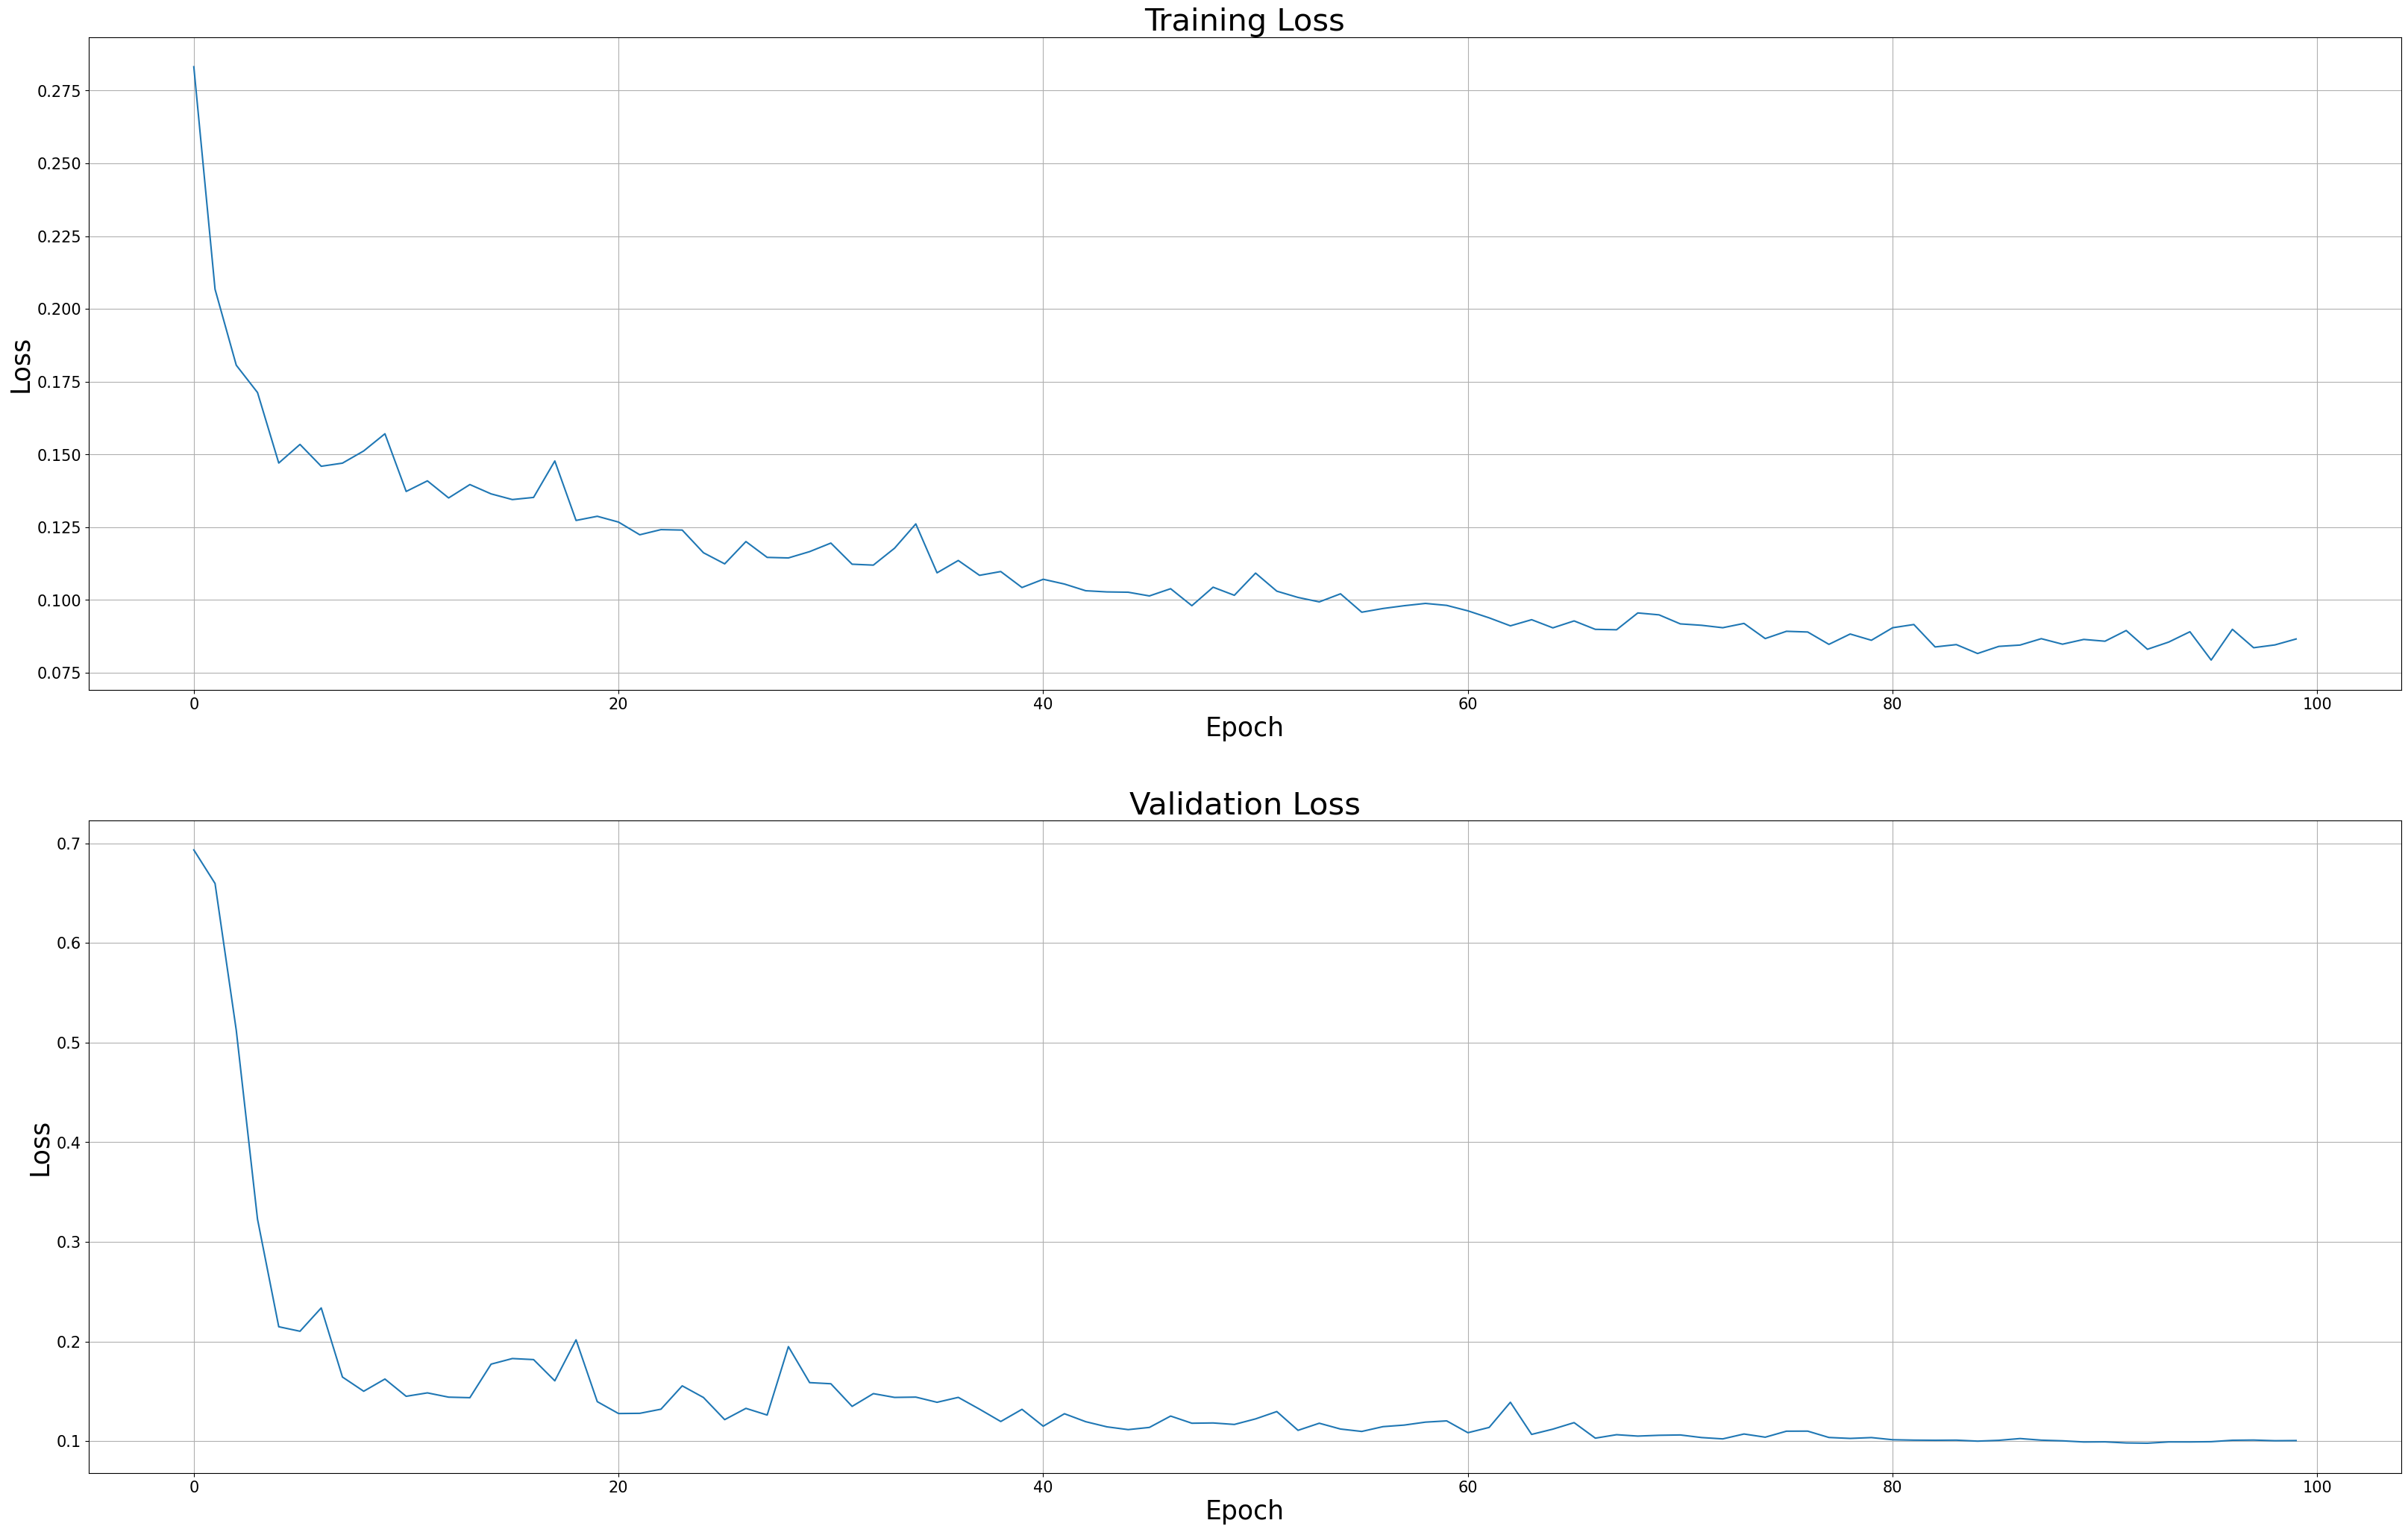

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25))
ax1.plot(train_losses, label="Train Loss")
ax2.plot(val_losses, label="Val Loss")
ax1.set_xlabel("Epoch", fontsize=25)
ax2.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Loss", fontsize=25)
ax2.set_ylabel("Loss", fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("Training Loss", fontsize=30)
ax2.set_title("Validation Loss", fontsize=30)
ax1.grid()
ax2.grid()
plt.show()

## Plain UNET

In [5]:
train_dir = os.path.join(full_dir, "chips/e2e/chips_6_27")
test_dir = os.path.join(full_dir, "chips/e2e/val_chips_e2e")

In [10]:
model = OceanColorUNET(in_channels=12, out_channels=1)

In [12]:
# ADJUST FOR TRAINING UNET VS SATVISION
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dir, test_dir, num_inputs=12, batch_size=64
)

num_epochs = 100
save_every = 20
test_every = 10
save_path = "e2e_unet"
pdf_path = "pred_pdfs/e2e"
metrics_filename = "e2e_metrics"
train_losses, val_losses = train_model(
    model, train_dataloader, val_dataloader, test_dataloader, num_epochs=num_epochs, 
    save_path=save_path, save_every=save_every, test_every=test_every, pdf_path=pdf_path, 
    metrics_filename=metrics_filename
)

/panfs/ccds02/nobackup/people/ajkerr1/SatVision/OceanColor/fine_tuning/ocean_color_transforms.py:147: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


Data shape: torch.Size([12, 128, 128])
Label shape: torch.Size([1, 128, 128])
train & val size: (144, 37)
Starting training for 100 epochs on cuda
Model parameters: 1,817,217


Epoch 1/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.191258, Avg=0.170490, LR=1.00e-04]
                                                                                                            
Epoch 1/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.183917, MAE=0.176815]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   1%|          | 1/100 [00:10<17:22, 10.53s/it, Train_Loss=0.1705, Val_Loss=0.1839, Val_MAE=0.1768, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_11_1ep.pdf



Epoch 2/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.149380, Avg=0.159123, LR=1.00e-04]
                                                                                                            
Epoch 2/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.177928, MAE=0.171009]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   2%|▏         | 2/100 [00:21<17:15, 10.57s/it, Train_Loss=0.1591, Val_Loss=0.1779, Val_MAE=0.1710, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_11_2ep.pdf



Epoch 3/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.106204, Avg=0.150483, LR=9.99e-05]
                                                                                                            
Epoch 3/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.172594, MAE=0.165837]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   3%|▎         | 3/100 [00:31<17:11, 10.63s/it, Train_Loss=0.1505, Val_Loss=0.1726, Val_MAE=0.1658, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_11_3ep.pdf



Epoch 4/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.205180, Avg=0.162053, LR=9.98e-05]
                                                                                                            
Epoch 4/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.162852, MAE=0.156218]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   4%|▍         | 4/100 [00:42<17:02, 10.66s/it, Train_Loss=0.1621, Val_Loss=0.1629, Val_MAE=0.1562, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_11_4ep.pdf



Epoch 5/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.172371, Avg=0.153551, LR=9.96e-05]
                                                                                                            
Epoch 5/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.157650, MAE=0.151080]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   5%|▌         | 5/100 [00:53<16:53, 10.67s/it, Train_Loss=0.1536, Val_Loss=0.1576, Val_MAE=0.1511, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_11_5ep.pdf



Epoch 6/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.163191, Avg=0.151052, LR=9.94e-05]
                                                                                                            
Epoch 6/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, Loss=0.152343, MAE=0.145806]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   6%|▌         | 6/100 [01:04<16:48, 10.73s/it, Train_Loss=0.1511, Val_Loss=0.1523, Val_MAE=0.1458, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_12_6ep.pdf



Epoch 7/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.135642, Avg=0.145729, LR=9.91e-05]
                                                                                                            
Epoch 7/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, Loss=0.149352, MAE=0.142854]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   7%|▋         | 7/100 [01:15<16:49, 10.86s/it, Train_Loss=0.1457, Val_Loss=0.1494, Val_MAE=0.1429, Time=11.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_12_7ep.pdf



Epoch 8/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.196651, Avg=0.153741, LR=9.88e-05]
                                                                                                            
Epoch 8/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, Loss=0.148352, MAE=0.141907]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   8%|▊         | 8/100 [01:26<16:43, 10.90s/it, Train_Loss=0.1537, Val_Loss=0.1484, Val_MAE=0.1419, Time=11.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_12_8ep.pdf



Epoch 9/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.170220, Avg=0.148004, LR=9.84e-05]
                                                                                                            
Epoch 9/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, Loss=0.149282, MAE=0.142769]
                                                                                             

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:   9%|▉         | 9/100 [01:37<16:34, 10.93s/it, Train_Loss=0.1480, Val_Loss=0.1493, Val_MAE=0.1428, Time=11.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_12_9ep.pdf



Epoch 10/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.160612, Avg=0.144828, LR=9.80e-05]
                                                                                                             
Epoch 10/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, Loss=0.142449, MAE=0.136019]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  10%|█         | 10/100 [01:53<19:06, 12.74s/it, Train_Loss=0.1448, Val_Loss=0.1424, Val_MAE=0.1360, Time=16.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_12_10ep.pdf



Epoch 11/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.152479, Avg=0.142648, LR=9.76e-05]
                                                                                                             
Epoch 11/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, Loss=0.143413, MAE=0.137034]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  11%|█         | 11/100 [02:04<17:52, 12.05s/it, Train_Loss=0.1426, Val_Loss=0.1434, Val_MAE=0.1370, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_11ep.pdf



Epoch 12/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.196293, Avg=0.152177, LR=9.71e-05]
                                                                                                             
Epoch 12/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.139577, MAE=0.133193]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  12%|█▏        | 12/100 [02:14<16:58, 11.58s/it, Train_Loss=0.1522, Val_Loss=0.1396, Val_MAE=0.1332, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_12ep.pdf



Epoch 13/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.152679, Avg=0.142017, LR=9.65e-05]
                                                                                                             
Epoch 13/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, Loss=0.152897, MAE=0.146387]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  13%|█▎        | 13/100 [02:25<16:19, 11.26s/it, Train_Loss=0.1420, Val_Loss=0.1529, Val_MAE=0.1464, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_13ep.pdf



Epoch 14/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.124323, Avg=0.136552, LR=9.59e-05]
                                                                                                             
Epoch 14/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.143578, MAE=0.137070]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  14%|█▍        | 14/100 [02:35<15:48, 11.03s/it, Train_Loss=0.1366, Val_Loss=0.1436, Val_MAE=0.1371, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_14ep.pdf



Epoch 15/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.157729, Avg=0.142053, LR=9.53e-05]
                                                                                                             
Epoch 15/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.150502, MAE=0.144120]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  15%|█▌        | 15/100 [02:47<15:38, 11.04s/it, Train_Loss=0.1421, Val_Loss=0.1505, Val_MAE=0.1441, Time=11.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_15ep.pdf



Epoch 16/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.190254, Avg=0.148147, LR=9.46e-05]
                                                                                                             
Epoch 16/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.135123, MAE=0.128781]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  16%|█▌        | 16/100 [02:57<15:13, 10.88s/it, Train_Loss=0.1481, Val_Loss=0.1351, Val_MAE=0.1288, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_13_16ep.pdf



Epoch 17/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.164576, Avg=0.139994, LR=9.39e-05]
                                                                                                             
Epoch 17/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.137955, MAE=0.131619]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  17%|█▋        | 17/100 [03:08<14:54, 10.78s/it, Train_Loss=0.1400, Val_Loss=0.1380, Val_MAE=0.1316, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_14_17ep.pdf



Epoch 18/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.206933, Avg=0.147430, LR=9.31e-05]
                                                                                                             
Epoch 18/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, Loss=0.137417, MAE=0.131081]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  18%|█▊        | 18/100 [03:18<14:37, 10.71s/it, Train_Loss=0.1474, Val_Loss=0.1374, Val_MAE=0.1311, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_14_18ep.pdf



Epoch 19/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.131918, Avg=0.134740, LR=9.23e-05]
                                                                                                             
Epoch 19/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, Loss=0.140099, MAE=0.133711]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  19%|█▉        | 19/100 [03:29<14:23, 10.66s/it, Train_Loss=0.1347, Val_Loss=0.1401, Val_MAE=0.1337, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_14_19ep.pdf



Epoch 20/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.115730, Avg=0.130633, LR=9.14e-05]
                                                                                                             
Epoch 20/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, Loss=0.134646, MAE=0.128306]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  20%|██        | 20/100 [03:39<14:11, 10.64s/it, Train_Loss=0.1306, Val_Loss=0.1346, Val_MAE=0.1283, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_14_20ep.pdf
New best model saved at epoch 20! Val Loss: 0.134646



Epoch 21/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.131814, Avg=0.131209, LR=9.05e-05]
                                                                                                             
Epoch 21/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.126467, MAE=0.120157]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  21%|██        | 21/100 [03:51<14:15, 10.83s/it, Train_Loss=0.1312, Val_Loss=0.1265, Val_MAE=0.1202, Time=11.3s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_14_21ep.pdf



Epoch 22/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.186251, Avg=0.138560, LR=8.96e-05]
                                                                                                             
Epoch 22/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.131105, MAE=0.124808]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  22%|██▏       | 22/100 [04:01<13:59, 10.76s/it, Train_Loss=0.1386, Val_Loss=0.1311, Val_MAE=0.1248, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_22ep.pdf



Epoch 23/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.127975, Avg=0.132225, LR=8.86e-05]
                                                                                                             
Epoch 23/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.127395, MAE=0.121101]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  23%|██▎       | 23/100 [04:12<13:43, 10.70s/it, Train_Loss=0.1322, Val_Loss=0.1274, Val_MAE=0.1211, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_23ep.pdf



Epoch 24/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.128157, Avg=0.132611, LR=8.76e-05]
                                                                                                             
Epoch 24/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.127492, MAE=0.121192]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  24%|██▍       | 24/100 [04:22<13:30, 10.66s/it, Train_Loss=0.1326, Val_Loss=0.1275, Val_MAE=0.1212, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_24ep.pdf



Epoch 25/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.111059, Avg=0.126472, LR=8.66e-05]
                                                                                                             
Epoch 25/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.132438, MAE=0.126023]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  25%|██▌       | 25/100 [04:33<13:20, 10.67s/it, Train_Loss=0.1265, Val_Loss=0.1324, Val_MAE=0.1260, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_25ep.pdf



Epoch 26/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.168964, Avg=0.134696, LR=8.55e-05]
                                                                                                             
Epoch 26/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.127143, MAE=0.120861]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  26%|██▌       | 26/100 [04:44<13:08, 10.65s/it, Train_Loss=0.1347, Val_Loss=0.1271, Val_MAE=0.1209, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_26ep.pdf



Epoch 27/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.174552, Avg=0.135441, LR=8.44e-05]
                                                                                                             
Epoch 27/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.133253, MAE=0.126930]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  27%|██▋       | 27/100 [04:54<12:54, 10.62s/it, Train_Loss=0.1354, Val_Loss=0.1333, Val_MAE=0.1269, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_15_27ep.pdf



Epoch 28/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.116097, Avg=0.126249, LR=8.32e-05]
                                                                                                             
Epoch 28/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.129631, MAE=0.123420]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  28%|██▊       | 28/100 [05:05<12:44, 10.62s/it, Train_Loss=0.1262, Val_Loss=0.1296, Val_MAE=0.1234, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_28ep.pdf



Epoch 29/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.180605, Avg=0.137158, LR=8.21e-05]
                                                                                                             
Epoch 29/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.125863, MAE=0.119575]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  29%|██▉       | 29/100 [05:16<12:53, 10.90s/it, Train_Loss=0.1372, Val_Loss=0.1259, Val_MAE=0.1196, Time=11.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_29ep.pdf



Epoch 30/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.166142, Avg=0.131881, LR=8.08e-05]
                                                                                                             
Epoch 30/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.126203, MAE=0.119943]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  30%|███       | 30/100 [05:27<12:35, 10.79s/it, Train_Loss=0.1319, Val_Loss=0.1262, Val_MAE=0.1199, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_30ep.pdf



Epoch 31/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.103596, Avg=0.119963, LR=7.96e-05]
                                                                                                             
Epoch 31/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.124296, MAE=0.118038]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  31%|███       | 31/100 [05:37<12:19, 10.71s/it, Train_Loss=0.1200, Val_Loss=0.1243, Val_MAE=0.1180, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_31ep.pdf



Epoch 32/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.139072, Avg=0.124932, LR=7.83e-05]
                                                                                                             
Epoch 32/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.122753, MAE=0.116468]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  32%|███▏      | 32/100 [05:48<12:05, 10.66s/it, Train_Loss=0.1249, Val_Loss=0.1228, Val_MAE=0.1165, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_32ep.pdf



Epoch 33/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.093545, Avg=0.117059, LR=7.70e-05]
                                                                                                             
Epoch 33/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.119395, MAE=0.113185]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  33%|███▎      | 33/100 [05:58<11:51, 10.62s/it, Train_Loss=0.1171, Val_Loss=0.1194, Val_MAE=0.1132, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_16_33ep.pdf



Epoch 34/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.194661, Avg=0.133185, LR=7.57e-05]
                                                                                                             
Epoch 34/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, Loss=0.121019, MAE=0.114787]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  34%|███▍      | 34/100 [06:09<11:39, 10.60s/it, Train_Loss=0.1332, Val_Loss=0.1210, Val_MAE=0.1148, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_17_34ep.pdf



Epoch 35/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.144497, Avg=0.123853, LR=7.43e-05]
                                                                                                             
Epoch 35/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, Loss=0.124819, MAE=0.118533]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  35%|███▌      | 35/100 [06:19<11:27, 10.57s/it, Train_Loss=0.1239, Val_Loss=0.1248, Val_MAE=0.1185, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_17_35ep.pdf



Epoch 36/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.118296, Avg=0.120304, LR=7.30e-05]
                                                                                                             
Epoch 36/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.116778, MAE=0.110608]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  36%|███▌      | 36/100 [06:30<11:15, 10.55s/it, Train_Loss=0.1203, Val_Loss=0.1168, Val_MAE=0.1106, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_17_36ep.pdf



Epoch 37/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.150339, Avg=0.125288, LR=7.16e-05]
                                                                                                             
Epoch 37/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.130205, MAE=0.123936]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  37%|███▋      | 37/100 [06:41<11:05, 10.56s/it, Train_Loss=0.1253, Val_Loss=0.1302, Val_MAE=0.1239, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_17_37ep.pdf



Epoch 38/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.164281, Avg=0.127094, LR=7.02e-05]
                                                                                                             
Epoch 38/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.123236, MAE=0.117042]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  38%|███▊      | 38/100 [06:52<11:16, 10.91s/it, Train_Loss=0.1271, Val_Loss=0.1232, Val_MAE=0.1170, Time=11.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_17_38ep.pdf



Epoch 39/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.165569, Avg=0.126567, LR=6.87e-05]
                                                                                                             
Epoch 39/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.122390, MAE=0.116200]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  39%|███▉      | 39/100 [07:03<10:59, 10.81s/it, Train_Loss=0.1266, Val_Loss=0.1224, Val_MAE=0.1162, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_39ep.pdf



Epoch 40/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.141244, Avg=0.120953, LR=6.73e-05]
                                                                                                             
Epoch 40/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.117483, MAE=0.111343]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  40%|████      | 40/100 [07:13<10:44, 10.74s/it, Train_Loss=0.1210, Val_Loss=0.1175, Val_MAE=0.1113, Time=10.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_40ep.pdf
New best model saved at epoch 40! Val Loss: 0.117483



Epoch 41/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.140120, Avg=0.120085, LR=6.58e-05]
                                                                                                             
Epoch 41/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.113732, MAE=0.107586]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  41%|████      | 41/100 [07:24<10:30, 10.69s/it, Train_Loss=0.1201, Val_Loss=0.1137, Val_MAE=0.1076, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_41ep.pdf



Epoch 42/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.152472, Avg=0.120497, LR=6.43e-05]
                                                                                                             
Epoch 42/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, Loss=0.115665, MAE=0.109519]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  42%|████▏     | 42/100 [07:35<10:19, 10.69s/it, Train_Loss=0.1205, Val_Loss=0.1157, Val_MAE=0.1095, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_42ep.pdf



Epoch 43/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.146510, Avg=0.118401, LR=6.28e-05]
                                                                                                             
Epoch 43/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.114374, MAE=0.108196]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  43%|████▎     | 43/100 [07:45<10:10, 10.72s/it, Train_Loss=0.1184, Val_Loss=0.1144, Val_MAE=0.1082, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_43ep.pdf



Epoch 44/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.135981, Avg=0.117874, LR=6.13e-05]
                                                                                                             
Epoch 44/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.115788, MAE=0.109612]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  44%|████▍     | 44/100 [07:56<09:59, 10.71s/it, Train_Loss=0.1179, Val_Loss=0.1158, Val_MAE=0.1096, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_18_44ep.pdf



Epoch 45/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.113543, Avg=0.114988, LR=5.98e-05]
                                                                                                             
Epoch 45/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.119630, MAE=0.113443]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  45%|████▌     | 45/100 [08:07<09:47, 10.68s/it, Train_Loss=0.1150, Val_Loss=0.1196, Val_MAE=0.1134, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_19_45ep.pdf



Epoch 46/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.136330, Avg=0.120661, LR=5.82e-05]
                                                                                                             
Epoch 46/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.118420, MAE=0.112304]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  46%|████▌     | 46/100 [08:17<09:36, 10.67s/it, Train_Loss=0.1207, Val_Loss=0.1184, Val_MAE=0.1123, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_19_46ep.pdf



Epoch 47/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.124277, Avg=0.115557, LR=5.67e-05]
                                                                                                             
Epoch 47/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.115975, MAE=0.109865]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  47%|████▋     | 47/100 [08:28<09:25, 10.68s/it, Train_Loss=0.1156, Val_Loss=0.1160, Val_MAE=0.1099, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_19_47ep.pdf



Epoch 48/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.145563, Avg=0.116937, LR=5.52e-05]
                                                                                                             
Epoch 48/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.113186, MAE=0.107048]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  48%|████▊     | 48/100 [08:39<09:14, 10.67s/it, Train_Loss=0.1169, Val_Loss=0.1132, Val_MAE=0.1070, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_19_48ep.pdf



Epoch 49/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.117138, Avg=0.112612, LR=5.36e-05]
                                                                                                             
Epoch 49/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.111023, MAE=0.104885]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  49%|████▉     | 49/100 [08:49<09:04, 10.67s/it, Train_Loss=0.1126, Val_Loss=0.1110, Val_MAE=0.1049, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_19_49ep.pdf



Epoch 50/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.127574, Avg=0.114101, LR=5.21e-05]
                                                                                                             
Epoch 50/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.115036, MAE=0.108922]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  50%|█████     | 50/100 [09:02<09:15, 11.11s/it, Train_Loss=0.1141, Val_Loss=0.1150, Val_MAE=0.1089, Time=12.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_50ep.pdf



Epoch 51/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.158094, Avg=0.120405, LR=5.05e-05]
                                                                                                             
Epoch 51/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, Loss=0.112049, MAE=0.105935]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  51%|█████     | 51/100 [09:12<08:58, 10.99s/it, Train_Loss=0.1204, Val_Loss=0.1120, Val_MAE=0.1059, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_51ep.pdf



Epoch 52/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.129475, Avg=0.114598, LR=4.89e-05]
                                                                                                             
Epoch 52/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.111002, MAE=0.104906]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  52%|█████▏    | 52/100 [09:23<08:43, 10.91s/it, Train_Loss=0.1146, Val_Loss=0.1110, Val_MAE=0.1049, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_52ep.pdf



Epoch 53/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.122940, Avg=0.112569, LR=4.74e-05]
                                                                                                             
Epoch 53/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.109699, MAE=0.103600]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  53%|█████▎    | 53/100 [09:34<08:29, 10.85s/it, Train_Loss=0.1126, Val_Loss=0.1097, Val_MAE=0.1036, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_53ep.pdf



Epoch 54/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.169825, Avg=0.119434, LR=4.58e-05]
                                                                                                             
Epoch 54/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.111212, MAE=0.105118]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  54%|█████▍    | 54/100 [09:44<08:17, 10.82s/it, Train_Loss=0.1194, Val_Loss=0.1112, Val_MAE=0.1051, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_54ep.pdf



Epoch 55/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.177198, Avg=0.120079, LR=4.43e-05]
                                                                                                             
Epoch 55/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, Loss=0.119474, MAE=0.113364]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  55%|█████▌    | 55/100 [09:55<08:04, 10.77s/it, Train_Loss=0.1201, Val_Loss=0.1195, Val_MAE=0.1134, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_20_55ep.pdf



Epoch 56/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.130388, Avg=0.115878, LR=4.28e-05]
                                                                                                             
Epoch 56/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.113233, MAE=0.107163]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  56%|█████▌    | 56/100 [10:06<07:52, 10.75s/it, Train_Loss=0.1159, Val_Loss=0.1132, Val_MAE=0.1072, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_21_56ep.pdf



Epoch 57/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.143905, Avg=0.114445, LR=4.12e-05]
                                                                                                             
Epoch 57/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.111309, MAE=0.105270]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  57%|█████▋    | 57/100 [10:17<07:42, 10.76s/it, Train_Loss=0.1144, Val_Loss=0.1113, Val_MAE=0.1053, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_21_57ep.pdf



Epoch 58/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.124337, Avg=0.112488, LR=3.97e-05]
                                                                                                             
Epoch 58/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.112833, MAE=0.106782]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  58%|█████▊    | 58/100 [10:27<07:31, 10.76s/it, Train_Loss=0.1125, Val_Loss=0.1128, Val_MAE=0.1068, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_21_58ep.pdf



Epoch 59/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.37it/s, Loss=0.120117, Avg=0.110911, LR=3.82e-05]
                                                                                                             
Epoch 59/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.108929, MAE=0.102857]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  59%|█████▉    | 59/100 [10:38<07:19, 10.73s/it, Train_Loss=0.1109, Val_Loss=0.1089, Val_MAE=0.1029, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_21_59ep.pdf



Epoch 60/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.151688, Avg=0.116861, LR=3.67e-05]
                                                                                                             
Epoch 60/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.109936, MAE=0.103840]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  60%|██████    | 60/100 [10:49<07:09, 10.73s/it, Train_Loss=0.1169, Val_Loss=0.1099, Val_MAE=0.1038, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_21_60ep.pdf
New best model saved at epoch 60! Val Loss: 0.109936



Epoch 61/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.162207, Avg=0.116428, LR=3.52e-05]
                                                                                                             
Epoch 61/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.112088, MAE=0.105998]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  61%|██████    | 61/100 [11:00<06:58, 10.74s/it, Train_Loss=0.1164, Val_Loss=0.1121, Val_MAE=0.1060, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_61ep.pdf



Epoch 62/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.191286, Avg=0.122374, LR=3.37e-05]
                                                                                                             
Epoch 62/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.111010, MAE=0.104957]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  62%|██████▏   | 62/100 [11:10<06:49, 10.78s/it, Train_Loss=0.1224, Val_Loss=0.1110, Val_MAE=0.1050, Time=10.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_62ep.pdf



Epoch 63/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.139580, Avg=0.112327, LR=3.23e-05]
                                                                                                             
Epoch 63/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.108550, MAE=0.102522]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  63%|██████▎   | 63/100 [11:21<06:38, 10.76s/it, Train_Loss=0.1123, Val_Loss=0.1086, Val_MAE=0.1025, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_63ep.pdf



Epoch 64/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.139088, Avg=0.111601, LR=3.08e-05]
                                                                                                             
Epoch 64/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.112055, MAE=0.105990]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  64%|██████▍   | 64/100 [11:32<06:27, 10.78s/it, Train_Loss=0.1116, Val_Loss=0.1121, Val_MAE=0.1060, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_64ep.pdf



Epoch 65/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.176161, Avg=0.117438, LR=2.94e-05]
                                                                                                             
Epoch 65/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.106563, MAE=0.100535]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  65%|██████▌   | 65/100 [11:44<06:35, 11.31s/it, Train_Loss=0.1174, Val_Loss=0.1066, Val_MAE=0.1005, Time=12.5s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_65ep.pdf



Epoch 66/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.144482, Avg=0.112273, LR=2.80e-05]
                                                                                                             
Epoch 66/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.107878, MAE=0.101875]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  66%|██████▌   | 66/100 [11:55<06:19, 11.15s/it, Train_Loss=0.1123, Val_Loss=0.1079, Val_MAE=0.1019, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_22_66ep.pdf



Epoch 67/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.161594, Avg=0.116112, LR=2.67e-05]
                                                                                                             
Epoch 67/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.106547, MAE=0.100574]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  67%|██████▋   | 67/100 [12:06<06:04, 11.04s/it, Train_Loss=0.1161, Val_Loss=0.1065, Val_MAE=0.1006, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_23_67ep.pdf



Epoch 68/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.120627, Avg=0.107836, LR=2.53e-05]
                                                                                                             
Epoch 68/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.104493, MAE=0.098474]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  68%|██████▊   | 68/100 [12:17<05:50, 10.95s/it, Train_Loss=0.1078, Val_Loss=0.1045, Val_MAE=0.0985, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_23_68ep.pdf



Epoch 69/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.152934, Avg=0.113552, LR=2.40e-05]
                                                                                                             
Epoch 69/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.104424, MAE=0.098425]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  69%|██████▉   | 69/100 [12:28<05:38, 10.91s/it, Train_Loss=0.1136, Val_Loss=0.1044, Val_MAE=0.0984, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_23_69ep.pdf



Epoch 70/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.118241, Avg=0.106555, LR=2.27e-05]
                                                                                                             
Epoch 70/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.105852, MAE=0.099862]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  70%|███████   | 70/100 [12:38<05:26, 10.87s/it, Train_Loss=0.1066, Val_Loss=0.1059, Val_MAE=0.0999, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_23_70ep.pdf



Epoch 71/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.149796, Avg=0.111174, LR=2.14e-05]
                                                                                                             
Epoch 71/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, Loss=0.105627, MAE=0.099635]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  71%|███████   | 71/100 [12:49<05:14, 10.84s/it, Train_Loss=0.1112, Val_Loss=0.1056, Val_MAE=0.0996, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_23_71ep.pdf



Epoch 72/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.196139, Avg=0.119525, LR=2.02e-05]
                                                                                                             
Epoch 72/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.104678, MAE=0.098694]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  72%|███████▏  | 72/100 [13:00<05:01, 10.78s/it, Train_Loss=0.1195, Val_Loss=0.1047, Val_MAE=0.0987, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_72ep.pdf



Epoch 73/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.139368, Avg=0.108661, LR=1.89e-05]
                                                                                                             
Epoch 73/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.104200, MAE=0.098225]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  73%|███████▎  | 73/100 [13:11<04:51, 10.78s/it, Train_Loss=0.1087, Val_Loss=0.1042, Val_MAE=0.0982, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_73ep.pdf



Epoch 74/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.140485, Avg=0.108873, LR=1.78e-05]
                                                                                                             
Epoch 74/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.105127, MAE=0.099128]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  74%|███████▍  | 74/100 [13:21<04:39, 10.74s/it, Train_Loss=0.1089, Val_Loss=0.1051, Val_MAE=0.0991, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_74ep.pdf



Epoch 75/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.162335, Avg=0.113361, LR=1.66e-05]
                                                                                                             
Epoch 75/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.106440, MAE=0.100423]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  75%|███████▌  | 75/100 [13:32<04:27, 10.70s/it, Train_Loss=0.1134, Val_Loss=0.1064, Val_MAE=0.1004, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_75ep.pdf



Epoch 76/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.125121, Avg=0.105972, LR=1.55e-05]
                                                                                                             
Epoch 76/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, Loss=0.105413, MAE=0.099413]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  76%|███████▌  | 76/100 [13:42<04:16, 10.68s/it, Train_Loss=0.1060, Val_Loss=0.1054, Val_MAE=0.0994, Time=10.6s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_76ep.pdf



Epoch 77/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.126601, Avg=0.107317, LR=1.44e-05]
                                                                                                             
Epoch 77/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.104429, MAE=0.098436]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  77%|███████▋  | 77/100 [13:53<04:05, 10.69s/it, Train_Loss=0.1073, Val_Loss=0.1044, Val_MAE=0.0984, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_24_77ep.pdf



Epoch 78/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.118345, Avg=0.105091, LR=1.34e-05]
                                                                                                             
Epoch 78/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, Loss=0.104693, MAE=0.098719]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  78%|███████▊  | 78/100 [14:04<03:54, 10.68s/it, Train_Loss=0.1051, Val_Loss=0.1047, Val_MAE=0.0987, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_25_78ep.pdf



Epoch 79/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.146445, Avg=0.110698, LR=1.24e-05]
                                                                                                             
Epoch 79/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, Loss=0.103090, MAE=0.097130]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  79%|███████▉  | 79/100 [14:15<03:44, 10.70s/it, Train_Loss=0.1107, Val_Loss=0.1031, Val_MAE=0.0971, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_25_79ep.pdf



Epoch 80/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.36it/s, Loss=0.156948, Avg=0.111288, LR=1.14e-05]
                                                                                                             
Epoch 80/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, Loss=0.103202, MAE=0.097240]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  80%|████████  | 80/100 [14:25<03:34, 10.73s/it, Train_Loss=0.1113, Val_Loss=0.1032, Val_MAE=0.0972, Time=10.7s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_25_80ep.pdf
New best model saved at epoch 80! Val Loss: 0.103202



Epoch 81/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.129791, Avg=0.107537, LR=1.05e-05]
                                                                                                             
Epoch 81/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, Loss=0.104080, MAE=0.098126]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  81%|████████  | 81/100 [14:36<03:24, 10.75s/it, Train_Loss=0.1075, Val_Loss=0.1041, Val_MAE=0.0981, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_25_81ep.pdf



Epoch 82/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.186800, Avg=0.116145, LR=9.56e-06]
                                                                                                             
Epoch 82/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, Loss=0.103606, MAE=0.097649]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  82%|████████▏ | 82/100 [14:47<03:13, 10.76s/it, Train_Loss=0.1161, Val_Loss=0.1036, Val_MAE=0.0976, Time=10.8s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_25_82ep.pdf



Epoch 83/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.106147, Avg=0.102154, LR=8.71e-06]
                                                                                                             
Epoch 83/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, Loss=0.101715, MAE=0.095768]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  83%|████████▎ | 83/100 [15:00<03:14, 11.42s/it, Train_Loss=0.1022, Val_Loss=0.1017, Val_MAE=0.0958, Time=13.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_83ep.pdf



Epoch 84/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.121263, Avg=0.105206, LR=7.89e-06]
                                                                                                             
Epoch 84/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, Loss=0.101958, MAE=0.096010]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  84%|████████▍ | 84/100 [15:11<03:00, 11.27s/it, Train_Loss=0.1052, Val_Loss=0.1020, Val_MAE=0.0960, Time=10.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_84ep.pdf



Epoch 85/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.125972, Avg=0.105449, LR=7.12e-06]
                                                                                                             
Epoch 85/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, Loss=0.101821, MAE=0.095879]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  85%|████████▌ | 85/100 [15:22<02:47, 11.16s/it, Train_Loss=0.1054, Val_Loss=0.1018, Val_MAE=0.0959, Time=10.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_85ep.pdf



Epoch 86/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.158971, Avg=0.110891, LR=6.40e-06]
                                                                                                             
Epoch 86/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, Loss=0.102637, MAE=0.096711]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  86%|████████▌ | 86/100 [15:33<02:35, 11.11s/it, Train_Loss=0.1109, Val_Loss=0.1026, Val_MAE=0.0967, Time=11.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_86ep.pdf



Epoch 87/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.140437, Avg=0.108329, LR=5.71e-06]
                                                                                                             
Epoch 87/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, Loss=0.103491, MAE=0.097539]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  87%|████████▋ | 87/100 [15:44<02:23, 11.07s/it, Train_Loss=0.1083, Val_Loss=0.1035, Val_MAE=0.0975, Time=11.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_87ep.pdf



Epoch 88/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.135224, Avg=0.107962, LR=5.07e-06]
                                                                                                             
Epoch 88/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, Loss=0.102628, MAE=0.096693]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  88%|████████▊ | 88/100 [15:55<02:12, 11.03s/it, Train_Loss=0.1080, Val_Loss=0.1026, Val_MAE=0.0967, Time=10.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_26_88ep.pdf



Epoch 89/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.138808, Avg=0.107468, LR=4.48e-06]
                                                                                                             
Epoch 89/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, Loss=0.101745, MAE=0.095829]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  89%|████████▉ | 89/100 [16:06<02:01, 11.00s/it, Train_Loss=0.1075, Val_Loss=0.1017, Val_MAE=0.0958, Time=10.9s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_27_89ep.pdf



Epoch 90/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.125241, Avg=0.105535, LR=3.93e-06]
                                                                                                             
Epoch 90/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, Loss=0.102072, MAE=0.096141]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  90%|█████████ | 90/100 [16:17<01:50, 11.03s/it, Train_Loss=0.1055, Val_Loss=0.1021, Val_MAE=0.0961, Time=11.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_27_90ep.pdf



Epoch 91/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.35it/s, Loss=0.155843, Avg=0.108978, LR=3.42e-06]
                                                                                                             
Epoch 91/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, Loss=0.101949, MAE=0.096014]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  91%|█████████ | 91/100 [16:28<01:39, 11.03s/it, Train_Loss=0.1090, Val_Loss=0.1019, Val_MAE=0.0960, Time=11.0s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_27_91ep.pdf



Epoch 92/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.134368, Avg=0.106240, LR=2.97e-06]
                                                                                                             
Epoch 92/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, Loss=0.101978, MAE=0.096043]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  92%|█████████▏| 92/100 [16:39<01:28, 11.05s/it, Train_Loss=0.1062, Val_Loss=0.1020, Val_MAE=0.0960, Time=11.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_27_92ep.pdf



Epoch 93/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.169785, Avg=0.111824, LR=2.56e-06]
                                                                                                             
Epoch 93/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, Loss=0.101948, MAE=0.096005]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  93%|█████████▎| 93/100 [16:50<01:17, 11.10s/it, Train_Loss=0.1118, Val_Loss=0.1019, Val_MAE=0.0960, Time=11.2s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_27_93ep.pdf



Epoch 94/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.137188, Avg=0.106561, LR=2.19e-06]
                                                                                                             
Epoch 94/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, Loss=0.102050, MAE=0.096116]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  94%|█████████▍| 94/100 [17:01<01:06, 11.09s/it, Train_Loss=0.1066, Val_Loss=0.1021, Val_MAE=0.0961, Time=11.1s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_94ep.pdf



Epoch 95/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.106626, Avg=0.102175, LR=1.88e-06]
                                                                                                             
Epoch 95/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, Loss=0.101264, MAE=0.095328]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  95%|█████████▌| 95/100 [17:12<00:55, 11.11s/it, Train_Loss=0.1022, Val_Loss=0.1013, Val_MAE=0.0953, Time=11.2s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_95ep.pdf



Epoch 96/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.147723, Avg=0.108288, LR=1.61e-06]
                                                                                                             
Epoch 96/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, Loss=0.101649, MAE=0.095710]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  96%|█████████▌| 96/100 [17:23<00:44, 11.13s/it, Train_Loss=0.1083, Val_Loss=0.1016, Val_MAE=0.0957, Time=11.2s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_96ep.pdf



Epoch 97/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.34it/s, Loss=0.164516, Avg=0.110811, LR=1.39e-06]
                                                                                                             
Epoch 97/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, Loss=0.102174, MAE=0.096227]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  97%|█████████▋| 97/100 [17:35<00:33, 11.15s/it, Train_Loss=0.1108, Val_Loss=0.1022, Val_MAE=0.0962, Time=11.2s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_97ep.pdf



Epoch 98/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.33it/s, Loss=0.147749, Avg=0.108533, LR=1.22e-06]
                                                                                                             
Epoch 98/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, Loss=0.104266, MAE=0.098315]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  98%|█████████▊| 98/100 [17:46<00:22, 11.20s/it, Train_Loss=0.1085, Val_Loss=0.1043, Val_MAE=0.0983, Time=11.3s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_98ep.pdf



Epoch 99/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.33it/s, Loss=0.147206, Avg=0.109475, LR=1.10e-06]
                                                                                                             
Epoch 99/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, Loss=0.102087, MAE=0.096147]
                                                                                              

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress:  99%|█████████▉| 99/100 [17:57<00:11, 11.24s/it, Train_Loss=0.1095, Val_Loss=0.1021, Val_MAE=0.0961, Time=11.3s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_28_99ep.pdf



Epoch 100/100 [Train]:  83%|████████▎ | 5/6 [00:04<00:00,  1.33it/s, Loss=0.151464, Avg=0.109476, LR=1.02e-06]
                                                                                                              
Epoch 100/100 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, Loss=0.101174, MAE=0.095245]
                                                                                               

Starting testing...



Testing:   0%|          | 0/1 [00:00<?, ?it/s]/panfs/ccds02/app/modules/jupyter/ilab/jupyter-lab/ilab-juplab-env-NO-ipyleaflet-install-ipywidgets-directly/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Training Progress: 100%|██████████| 100/100 [18:09<00:00, 10.89s/it, Train_Loss=0.1095, Val_Loss=0.1012, Val_MAE=0.0952, Time=11.4s]

Plots saved to pred_pdfs/e2e/preds_day_2025_07_10_time_17_29_100ep.pdf
New best model saved at epoch 100! Val Loss: 0.101174

Training completed!
Best validation loss: 0.101174


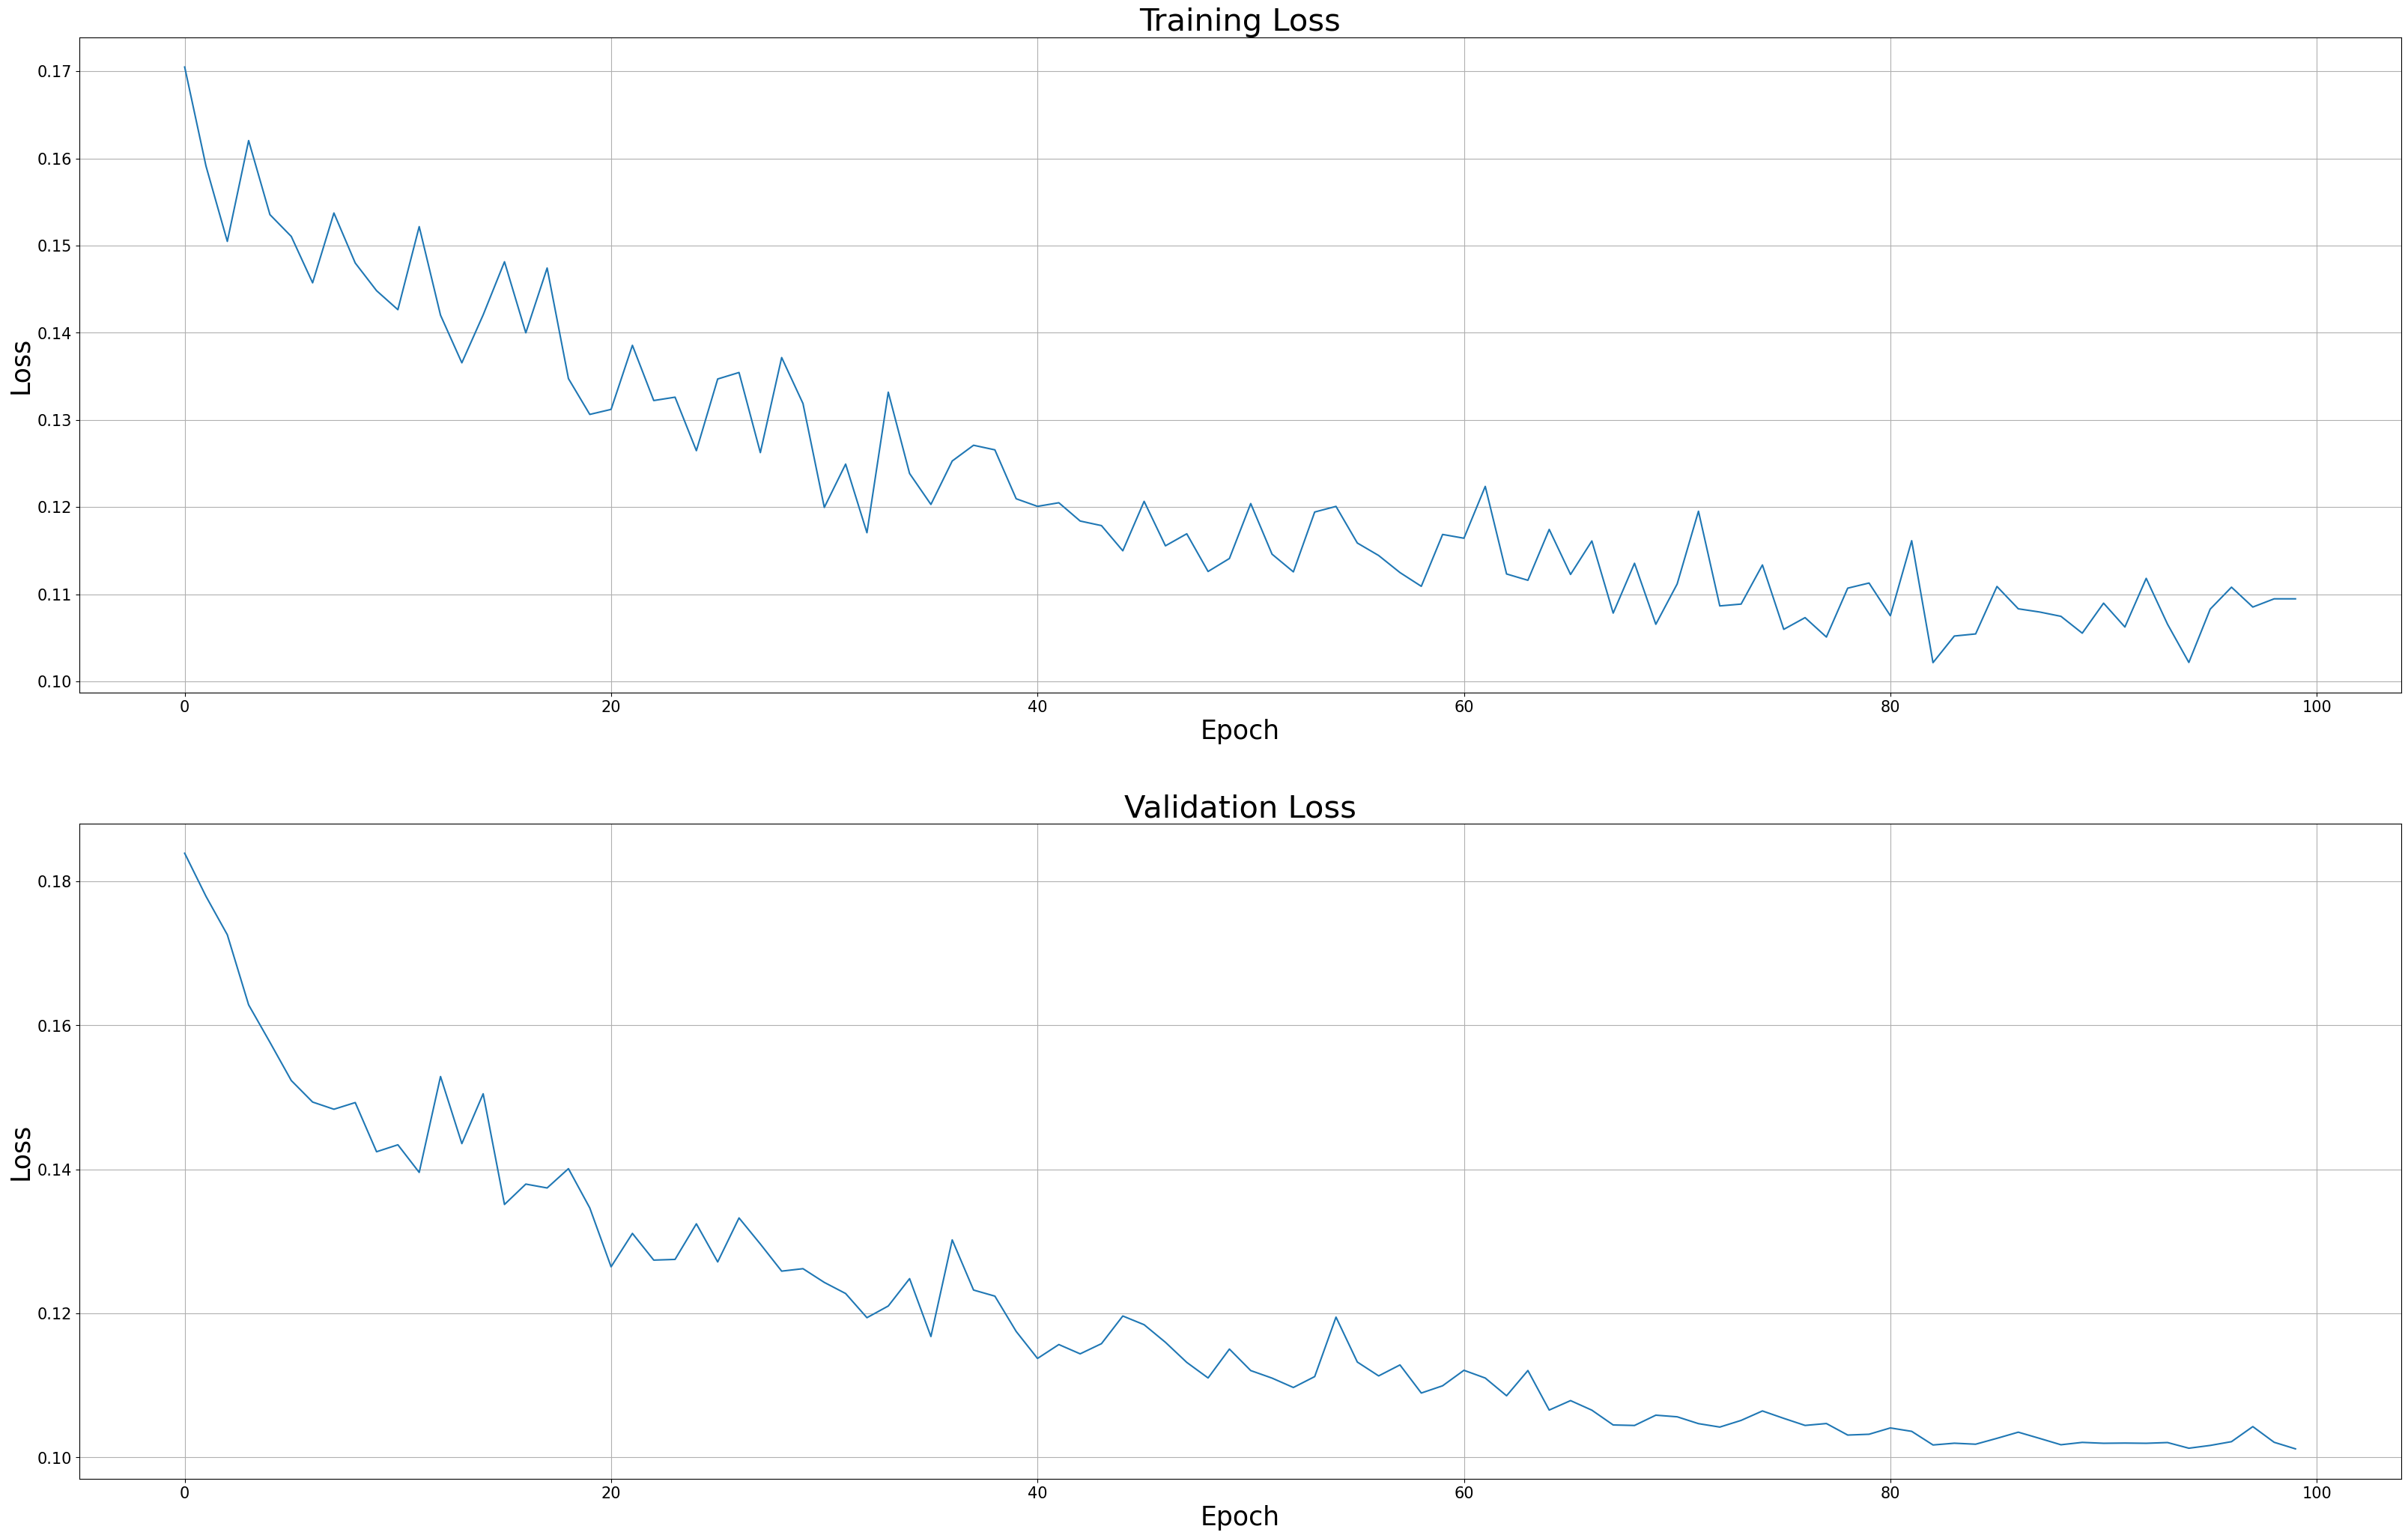

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25))
ax1.plot(train_losses, label="Train Loss")
ax2.plot(val_losses, label="Val Loss")
ax1.set_xlabel("Epoch", fontsize=25)
ax2.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Loss", fontsize=25)
ax2.set_ylabel("Loss", fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title("Training Loss", fontsize=30)
ax2.set_title("Validation Loss", fontsize=30)
ax1.grid()
ax2.grid()
plt.show()

<Axes: xlabel='epoch'>

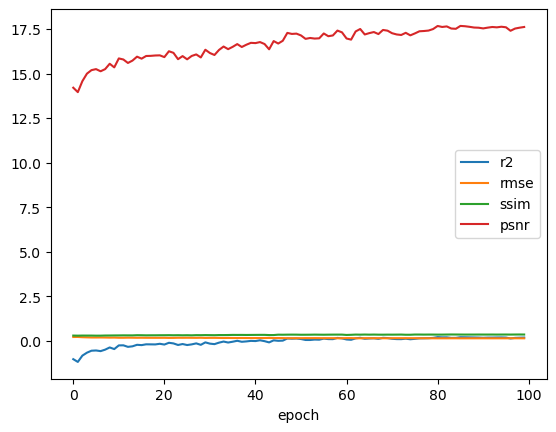

In [39]:
df = pd.read_csv('e2e_metrics_epoch_metrics_average.csv')
df = df[['epoch', 'r2', 'rmse', 'ssim', 'psnr']]
df.plot(x='epoch')

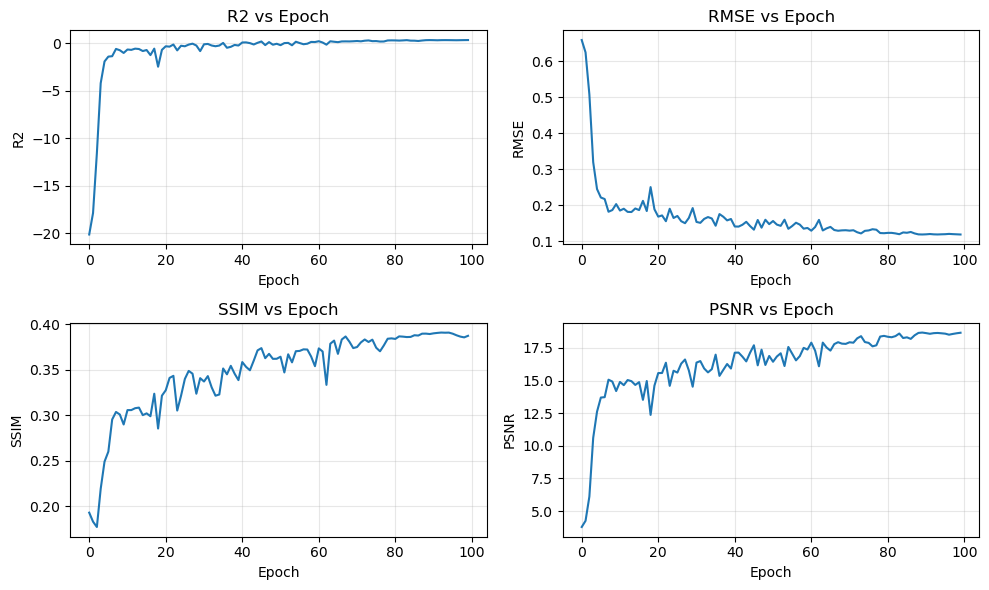

In [64]:
df = pd.read_csv('sv_metrics_epoch_metrics_average.csv')
df = df[['epoch', 'r2', 'rmse', 'ssim', 'psnr']]
df1 = df.iloc[0:21]
df2 = df.iloc[21:]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = np.array(axes).flatten()
metric_columns = ['r2', 'rmse', 'ssim', 'psnr']
for idx, metric in enumerate(metric_columns):
    axes[idx].plot(df['epoch'], df[metric], label=metric)
    axes[idx].set_title(f'{metric.upper()} vs Epoch')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].grid(True, alpha=0.3)
    axes[idx].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.tight_layout()
plt.show()

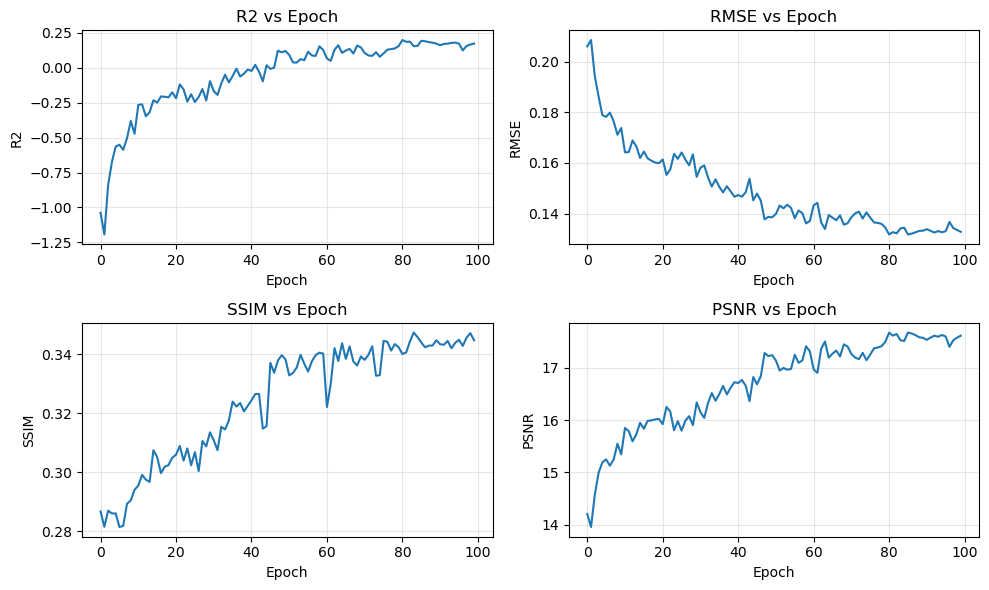

In [65]:
df = pd.read_csv('e2e_metrics_epoch_metrics_average.csv')
df = df[['epoch', 'r2', 'rmse', 'ssim', 'psnr']]
df1 = df.iloc[0:21]
df2 = df.iloc[21:]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = np.array(axes).flatten()
metric_columns = ['r2', 'rmse', 'ssim', 'psnr']
for idx, metric in enumerate(metric_columns):
    axes[idx].plot(df['epoch'], df[metric], label=metric)
    axes[idx].set_title(f'{metric.upper()} vs Epoch')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].grid(True, alpha=0.3)
    axes[idx].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.tight_layout()
plt.show()